In [19]:
# 다른 경로에 있는 모듈을 가져오기 위해 절대 경로 추가

import os
import sys

root = os.path.join(os.path.abspath(os.getcwd()), '..', '..')
root = os.path.normpath(root)

if root not in sys.path:
    sys.path.insert(0, root)

In [20]:
# 필요한 라이브러리 로드

import json
import matplotlib.pyplot as plt
import pandas as pd
import torch
from communav.utils import db
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

In [21]:
# 카테고리 정의

CATEGORIES = {
    1: '질문 · 답변',
    2: '학사 · 졸업',
    3: '장학 · 행정',
    4: '학교생활',
    5: '수업/이과',
    6: '수업/문과',
    7: '캠퍼스',
    8: '일상생활',
    9: '취미 · 여가',
    10: '인간관계',
    11: '취업 · 진로',
}

In [22]:
# 파라미터 설정

MODEL_ID = 'beomi/KcELECTRA-base-v2022'
MAX_LENGTH = 128
F_BETA = 0.5
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 2e-5
TARGET_CATEGORY = 7
ITERATION = 10
SAVE_PATH = '.'

In [23]:
# 커뮤니티 게시글 데이터 로드

connection = db.get_connection()
cursor = connection.cursor()

cursor.execute('''
    SELECT
        articles.id,
        articles.title,
        articles.text,
        labels.category_ids
    FROM everytime_original_articles articles
    JOIN everytime_article_labels labels ON articles.id = labels.article_id
''')
original_articles = cursor.fetchall()
print(f'Loaded {len(original_articles)} articles.')

cursor.close()
db.close_connection()

Connected to DB successfully.
Loaded 2392 articles.


In [24]:
# 가져온 데이터의 일부를 출력

for article in original_articles[:20]:
    print(article)

{'id': 100245988, 'title': '장학금 관련해서..', 'text': '성적장학금 + 한울장학금 가능한지 궁금합니다..', 'category_ids': '[1, 3]'}
{'id': 100634300, 'title': '배고파 집에가서', 'text': '진짬뽕에 밥 말아먹어야지 히힣', 'category_ids': '[]'}
{'id': 100656956, 'title': '부산 + 용인까지 의심 환자 발생', 'text': '평택시는 난리남.\n부산에서도..\n근데 이상한건 용인인데.\n그 분은 중국 갔다온사람 아니라던데?\n뭐냐 진짜..', 'category_ids': '[]'}
{'id': 100682214, 'title': '신종 코로나바이러스(2019-nCoV) 감염증 대처 방법', 'text': "원문은 의과교수 펨붕이가 펨코에 쓴 것. 지금도 질문받는듯.\n \n==========================================\n최근 우한에서 발생한 신종 코로나바이러스(2019-nCoV) 감염증으로 인해서 많은 우려를 가지고 계실 듯합니다. \n여러 인터넷 커뮤니티에서 많은 정보들이 돌아다니고, 이로 인해 혼란이 가중되는 모습을 연휴 동안 지켜보았습니다. \n \n저는 예방의학전문의로 현재 의과대학에서 교수로 일하고 있습니다. 감염내과 전공은 아니지만, 2015년부터 신종 감염병과 관련된 여러 경험이 있고, 메르스, 지카바이러스 감염증 등 신종감염병 유입 사례에서 정부 내에서 역학조사팀장으로도 일했습니다. 이후 여러 감염병과 관련된 학술적인 작업을 하고 있습니다.\n \n개인적으로는 다행히도 재작년에 교직으로 옮기면서 현장 대응과는 거리가 멀어졌지만, 여러분들에게 정확한 정보를 알려드리고, 위험 의사소통(Risk communication)을 적극적으로 수행하는 것이 얼마나 중요한지 잘 알고 있어서 현장에서 고생하시는 분들을 대신해서 소통에 나서게 되었습니다. 현재 이러한 업무를 수행하실 수 있는 능력을 가지신 훌륭한 

In [25]:
# 이진 분류 문제를 위한 데이터 전처리

preprocessed_articles = []

for article in original_articles:
    title = article['title']
    text = article['text']
    content = (title + ' ' + text).replace('\n', ' ').strip()
    label = 1 if TARGET_CATEGORY in json.loads(article['category_ids']) else 0

    preprocessed_articles.append({
        'content': content,
        'label': label
    })

In [26]:
# 전처리된 데이터의 일부를 출력

for article in preprocessed_articles[:20]:
    print(article)

{'content': '장학금 관련해서.. 성적장학금 + 한울장학금 가능한지 궁금합니다..', 'label': 0}
{'content': '배고파 집에가서 진짬뽕에 밥 말아먹어야지 히힣', 'label': 0}
{'content': '부산 + 용인까지 의심 환자 발생 평택시는 난리남. 부산에서도.. 근데 이상한건 용인인데. 그 분은 중국 갔다온사람 아니라던데? 뭐냐 진짜..', 'label': 0}
{'content': "신종 코로나바이러스(2019-nCoV) 감염증 대처 방법 원문은 의과교수 펨붕이가 펨코에 쓴 것. 지금도 질문받는듯.   ========================================== 최근 우한에서 발생한 신종 코로나바이러스(2019-nCoV) 감염증으로 인해서 많은 우려를 가지고 계실 듯합니다.  여러 인터넷 커뮤니티에서 많은 정보들이 돌아다니고, 이로 인해 혼란이 가중되는 모습을 연휴 동안 지켜보았습니다.    저는 예방의학전문의로 현재 의과대학에서 교수로 일하고 있습니다. 감염내과 전공은 아니지만, 2015년부터 신종 감염병과 관련된 여러 경험이 있고, 메르스, 지카바이러스 감염증 등 신종감염병 유입 사례에서 정부 내에서 역학조사팀장으로도 일했습니다. 이후 여러 감염병과 관련된 학술적인 작업을 하고 있습니다.   개인적으로는 다행히도 재작년에 교직으로 옮기면서 현장 대응과는 거리가 멀어졌지만, 여러분들에게 정확한 정보를 알려드리고, 위험 의사소통(Risk communication)을 적극적으로 수행하는 것이 얼마나 중요한지 잘 알고 있어서 현장에서 고생하시는 분들을 대신해서 소통에 나서게 되었습니다. 현재 이러한 업무를 수행하실 수 있는 능력을 가지신 훌륭한 분들께서는 대부분 현장에서 나가 계셔서 저처럼 자리에 앉아 있으실 수 없을듯 합니다.     1. 신종 코로나 바이러스 감염증에 대해서 궁금하신 것이 있으시면 무엇이든 질문해주세요. 적극적으로 정보를 찾아서 제공해드리겠습니다. 어떠한 질문이든 관계없습니다. : 제가 2

In [27]:
# 데이터 분포 확인 함수 정의

def plot_distribution(articles):
    label_counts = [0, 0]
    for article in articles:
        label_counts[article['label']] += 1

    total_count = sum(label_counts)
    percentages = [count / total_count * 100 for count in label_counts]
    for i, percentage in enumerate(percentages):
        print(f'Label {i}: {percentage:.2f}%')

    plt.figure(figsize=(8, 6))
    plt.bar(['0', '1'], label_counts)
    plt.text(0, label_counts[0] + 0.1, str(label_counts[0]), ha='center')
    plt.text(1, label_counts[1] + 0.1, str(label_counts[1]), ha='center')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Labels')
    plt.show()

Label 0: 90.72%
Label 1: 9.28%


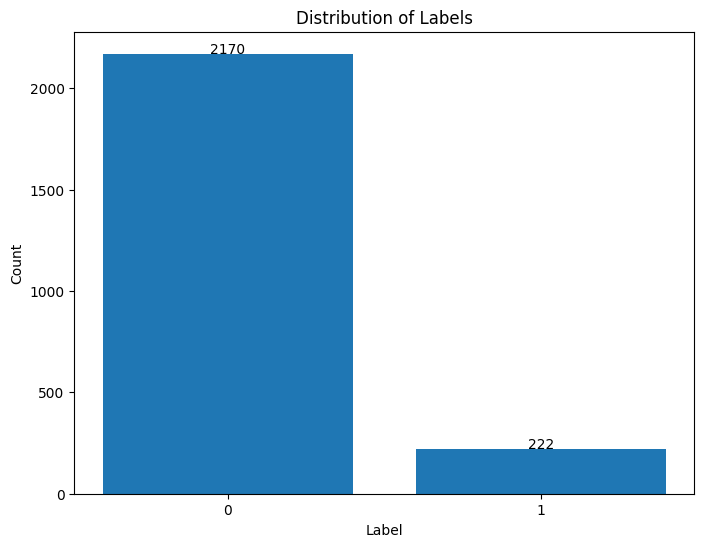

In [28]:
# 데이터 분포 확인

plot_distribution(preprocessed_articles)

In [29]:
# 훈련 데이터와 검증 데이터로 분리

train_articles, val_articles = train_test_split(
    preprocessed_articles,
    test_size=0.2,
    random_state=42
)

print(f'Number of training articles: {len(train_articles)}')
print(f'Number of validation articles: {len(val_articles)}')

Number of training articles: 1913
Number of validation articles: 479


Label 0: 90.49%
Label 1: 9.51%


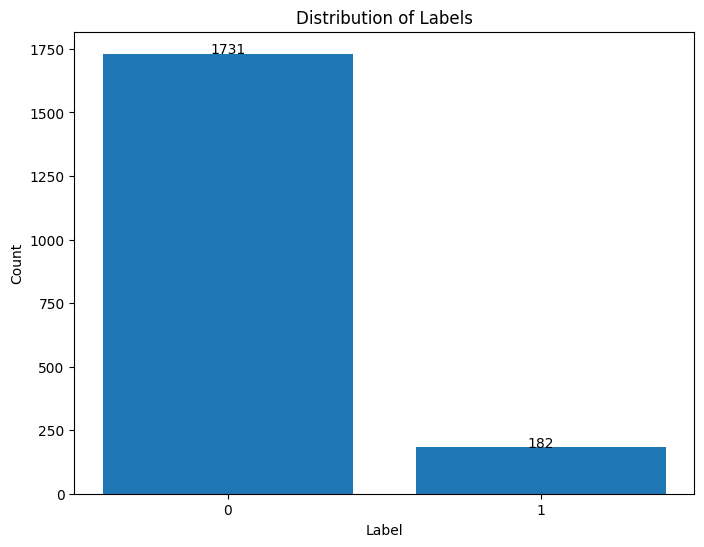

In [30]:
# 훈련 데이터의 데이터 분포 확인

plot_distribution(train_articles)

Label 0: 91.65%
Label 1: 8.35%


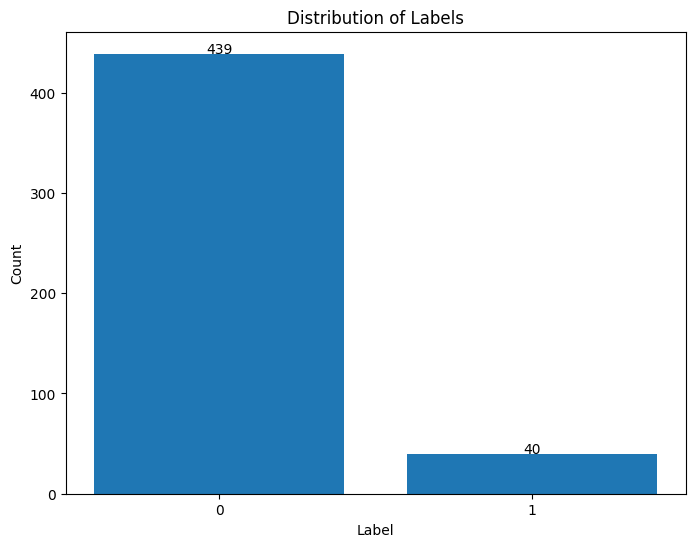

In [31]:
# 검증 데이터의 데이터 분포 확인

plot_distribution(val_articles)

In [32]:
# 토크나이저 로드

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

print('Original:', preprocessed_articles[0]['content'])
print('Tokenized:', tokenizer.tokenize(preprocessed_articles[0]['content']))

Original: 장학금 관련해서.. 성적장학금 + 한울장학금 가능한지 궁금합니다..
Tokenized: ['장학금', '관련해서', '.', '.', '성적', '##장', '##학', '##금', '+', '한울', '##장', '##학', '##금', '가능한', '##지', '궁금합니다', '.', '.']


In [33]:
# 텍스트 인코딩 및 데이터셋 생성

train_contents = [article['content'] for article in train_articles]
train_labels = [article['label'] for article in train_articles]
val_contents = [article['content'] for article in val_articles]
val_labels = [article['label'] for article in val_articles]

train_encodings = tokenizer(
    train_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
val_encodings = tokenizer(
    val_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)
val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels)
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

/tmp/ipykernel_13133/2848816050.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['input_ids']),
/tmp/ipykernel_13133/2848816050.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['attention_mask']),
/tmp/ipykernel_13133/2848816050.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_encodings['input_ids']),
/tmp/ipykernel_13133/2848816050.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTenso

In [34]:
# 평가 지표 계산 함수 정의

def calculate_metrics(true_labels, predicted_labels):
    acc = accuracy_score(true_labels, predicted_labels)
    prec = precision_score(true_labels, predicted_labels)
    rec = recall_score(true_labels, predicted_labels)
    f_beta = fbeta_score(true_labels, predicted_labels, beta=F_BETA)

    return acc, prec, rec, f_beta

In [35]:
# 학습 전 초기화

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060 Ti


In [36]:
# 학습 시작

best_val_f_beta = 0.0
best_model_path = None

for iteration in range(ITERATION):
    print(f'Iteration {iteration + 1}/{ITERATION}')

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=2)
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_dataset) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    better_val_f_beta = 0.0
    better_model_path = None

    for epoch in range(EPOCHS):
        model.train()

        train_loss = 0.0
        train_predictions = []
        train_labels_epoch = []

        for batch in tqdm(train_dataloader, desc=f'Iteration {iteration + 1} - Epoch {epoch + 1} - Training'):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            train_predictions.extend(predictions.tolist())
            train_labels_epoch.extend(labels.tolist())

        train_acc, train_prec, train_rec, train_f_beta = calculate_metrics(train_labels_epoch, train_predictions)
        train_loss /= len(train_dataloader)

        model.eval()

        val_loss = 0.0
        val_predictions = []

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f'Iteration {iteration + 1} - Epoch {epoch + 1} - Validation'):
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=1)

                val_predictions.extend(predictions.tolist())

        val_acc, val_prec, val_rec, val_f_beta = calculate_metrics(val_labels, val_predictions)
        val_loss /= len(val_dataloader)

        print(f'Iteration {iteration + 1} - Epoch {epoch + 1}:')
        print(f'  Train Acc = {train_acc:.4f}, Train Prec = {train_prec:.4f}, Train Rec = {train_rec:.4f}, Train F-Beta = {train_f_beta:.4f}, Train Loss = {train_loss:.4f}')
        print(f'  Val Acc = {val_acc:.4f}, Val Prec = {val_prec:.4f}, Val Rec = {val_rec:.4f}, Val F-Beta = {val_f_beta:.4f}, Val Loss = {val_loss:.4f}')

        if val_f_beta > better_val_f_beta:
            better_val_f_beta = val_f_beta
            better_model_path = f'{SAVE_PATH}/model-{TARGET_CATEGORY:02d}-iteration-{iteration + 1:02d}-epoch-{epoch + 1:02d}-{better_val_f_beta:.4f}'
            model.save_pretrained(better_model_path)
            tokenizer.save_pretrained(better_model_path)
            print(f'  Better model saved with {better_val_f_beta:.4f} F-beta score.')

    if better_val_f_beta > best_val_f_beta:
        best_val_f_beta = better_val_f_beta
        best_model_path = better_model_path

print('Training finished.')

Iteration 1/10


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Iteration 1 - Epoch 1 - Training: 100%|██████████| 60/60 [00:18<00:00,  3.32it/s]
/home/retn0/repositories/nbsp1221/communav/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Iteration 1 - Epoch 1 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.05it/s]
/home/retn0/repositories/nbsp1221/communav/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py

Iteration 1 - Epoch 1:
  Train Acc = 0.9049, Train Prec = 0.0000, Train Rec = 0.0000, Train F-Beta = 0.0000, Train Loss = 0.3418
  Val Acc = 0.9165, Val Prec = 0.0000, Val Rec = 0.0000, Val F-Beta = 0.0000, Val Loss = 0.2467


Iteration 1 - Epoch 2 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.94it/s]


Iteration 1 - Epoch 2:
  Train Acc = 0.9289, Train Prec = 0.7054, Train Rec = 0.4341, Train F-Beta = 0.6270, Train Loss = 0.1816
  Val Acc = 0.9207, Val Prec = 0.5139, Val Rec = 0.9250, Val F-Beta = 0.5640, Val Loss = 0.1687
  Better model saved with 0.5640 F-beta score.


Iteration 1 - Epoch 3 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.95it/s]


Iteration 1 - Epoch 3:
  Train Acc = 0.9676, Train Prec = 0.8226, Train Rec = 0.8407, Train F-Beta = 0.8261, Train Loss = 0.0994
  Val Acc = 0.9645, Val Prec = 0.7949, Val Rec = 0.7750, Val F-Beta = 0.7908, Val Loss = 0.1099
  Better model saved with 0.7908 F-beta score.


Iteration 1 - Epoch 4 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.09it/s]


Iteration 1 - Epoch 4:
  Train Acc = 0.9833, Train Prec = 0.9032, Train Rec = 0.9231, Train F-Beta = 0.9071, Train Loss = 0.0547
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.1091
  Better model saved with 0.8333 F-beta score.


Iteration 1 - Epoch 5 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.00it/s]


Iteration 1 - Epoch 5:
  Train Acc = 0.9916, Train Prec = 0.9611, Train Rec = 0.9505, Train F-Beta = 0.9590, Train Loss = 0.0333
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.1609


Iteration 1 - Epoch 6 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.10it/s]


Iteration 1 - Epoch 6:
  Train Acc = 0.9984, Train Prec = 0.9891, Train Rec = 0.9945, Train F-Beta = 0.9902, Train Loss = 0.0095
  Val Acc = 0.9582, Val Prec = 0.7174, Val Rec = 0.8250, Val F-Beta = 0.7366, Val Loss = 0.1767


Iteration 1 - Epoch 7 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Iteration 1 - Epoch 7:
  Train Acc = 0.9969, Train Prec = 0.9835, Train Rec = 0.9835, Train F-Beta = 0.9835, Train Loss = 0.0127
  Val Acc = 0.9603, Val Prec = 0.8000, Val Rec = 0.7000, Val F-Beta = 0.7778, Val Loss = 0.1979


Iteration 1 - Epoch 8 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.99it/s]


Iteration 1 - Epoch 8:
  Train Acc = 0.9963, Train Prec = 0.9781, Train Rec = 0.9835, Train F-Beta = 0.9792, Train Loss = 0.0144
  Val Acc = 0.9645, Val Prec = 0.7949, Val Rec = 0.7750, Val F-Beta = 0.7908, Val Loss = 0.1690


Iteration 1 - Epoch 9 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.91it/s]


Iteration 1 - Epoch 9:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0022
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.1889


Iteration 1 - Epoch 10 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.01it/s]


Iteration 1 - Epoch 10:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0019
  Val Acc = 0.9582, Val Prec = 0.7083, Val Rec = 0.8500, Val F-Beta = 0.7328, Val Loss = 0.2309


Iteration 1 - Epoch 11 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Iteration 1 - Epoch 11:
  Train Acc = 0.9948, Train Prec = 0.9725, Train Rec = 0.9725, Train F-Beta = 0.9725, Train Loss = 0.0189
  Val Acc = 0.9582, Val Prec = 0.7000, Val Rec = 0.8750, Val F-Beta = 0.7292, Val Loss = 0.1814


Iteration 1 - Epoch 12 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.02it/s]


Iteration 1 - Epoch 12:
  Train Acc = 0.9948, Train Prec = 0.9674, Train Rec = 0.9780, Train F-Beta = 0.9695, Train Loss = 0.0166
  Val Acc = 0.9603, Val Prec = 0.8000, Val Rec = 0.7000, Val F-Beta = 0.7778, Val Loss = 0.1955


Iteration 1 - Epoch 13 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Iteration 1 - Epoch 13:
  Train Acc = 0.9984, Train Prec = 0.9891, Train Rec = 0.9945, Train F-Beta = 0.9902, Train Loss = 0.0054
  Val Acc = 0.9645, Val Prec = 0.7949, Val Rec = 0.7750, Val F-Beta = 0.7908, Val Loss = 0.1986


Iteration 1 - Epoch 14 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.06it/s]


Iteration 1 - Epoch 14:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0012
  Val Acc = 0.9666, Val Prec = 0.8000, Val Rec = 0.8000, Val F-Beta = 0.8000, Val Loss = 0.2086


Iteration 1 - Epoch 15 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.06it/s]


Iteration 1 - Epoch 15:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0007
  Val Acc = 0.9666, Val Prec = 0.7857, Val Rec = 0.8250, Val F-Beta = 0.7933, Val Loss = 0.2090


Iteration 1 - Epoch 16 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.06it/s]


Iteration 1 - Epoch 16:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0007
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.2175


Iteration 1 - Epoch 17 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.97it/s]


Iteration 1 - Epoch 17:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.2247


Iteration 1 - Epoch 18 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.03it/s]


Iteration 1 - Epoch 18:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9666, Val Prec = 0.8000, Val Rec = 0.8000, Val F-Beta = 0.8000, Val Loss = 0.2416


Iteration 1 - Epoch 19 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.01it/s]


Iteration 1 - Epoch 19:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0027
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.2355


Iteration 1 - Epoch 20 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.93it/s]


Iteration 1 - Epoch 20:
  Train Acc = 0.9969, Train Prec = 0.9731, Train Rec = 0.9945, Train F-Beta = 0.9773, Train Loss = 0.0115
  Val Acc = 0.9520, Val Prec = 0.8400, Val Rec = 0.5250, Val F-Beta = 0.7500, Val Loss = 0.3011


Iteration 1 - Epoch 21 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.93it/s]


Iteration 1 - Epoch 21:
  Train Acc = 0.9948, Train Prec = 0.9725, Train Rec = 0.9725, Train F-Beta = 0.9725, Train Loss = 0.0133
  Val Acc = 0.9562, Val Prec = 0.7317, Val Rec = 0.7500, Val F-Beta = 0.7353, Val Loss = 0.2651


Iteration 1 - Epoch 22 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Iteration 1 - Epoch 22:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0023
  Val Acc = 0.9562, Val Prec = 0.7111, Val Rec = 0.8000, Val F-Beta = 0.7273, Val Loss = 0.2660


Iteration 1 - Epoch 23 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.96it/s]


Iteration 1 - Epoch 23:
  Train Acc = 0.9990, Train Prec = 1.0000, Train Rec = 0.9890, Train F-Beta = 0.9978, Train Loss = 0.0059
  Val Acc = 0.9541, Val Prec = 0.6667, Val Rec = 0.9000, Val F-Beta = 0.7031, Val Loss = 0.2375


Iteration 1 - Epoch 24 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]


Iteration 1 - Epoch 24:
  Train Acc = 0.9948, Train Prec = 0.9778, Train Rec = 0.9670, Train F-Beta = 0.9756, Train Loss = 0.0254
  Val Acc = 0.9645, Val Prec = 0.7674, Val Rec = 0.8250, Val F-Beta = 0.7783, Val Loss = 0.1486


Iteration 1 - Epoch 25 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.95it/s]


Iteration 1 - Epoch 25:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0009
  Val Acc = 0.9666, Val Prec = 0.7857, Val Rec = 0.8250, Val F-Beta = 0.7933, Val Loss = 0.1687


Iteration 1 - Epoch 26 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.98it/s]


Iteration 1 - Epoch 26:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0004
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.1858


Iteration 1 - Epoch 27 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.01it/s]


Iteration 1 - Epoch 27:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0007
  Val Acc = 0.9666, Val Prec = 0.7857, Val Rec = 0.8250, Val F-Beta = 0.7933, Val Loss = 0.1860


Iteration 1 - Epoch 28 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]


Iteration 1 - Epoch 28:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9666, Val Prec = 0.7857, Val Rec = 0.8250, Val F-Beta = 0.7933, Val Loss = 0.1944


Iteration 1 - Epoch 29 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Iteration 1 - Epoch 29:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2035


Iteration 1 - Epoch 30 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.99it/s]


Iteration 1 - Epoch 30:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2107


Iteration 1 - Epoch 31 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Iteration 1 - Epoch 31:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2136


Iteration 1 - Epoch 32 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.91it/s]


Iteration 1 - Epoch 32:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2171


Iteration 1 - Epoch 33 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Iteration 1 - Epoch 33:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2195


Iteration 1 - Epoch 34 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]


Iteration 1 - Epoch 34:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2239


Iteration 1 - Epoch 35 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 1 - Epoch 35:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2268


Iteration 1 - Epoch 36 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Iteration 1 - Epoch 36:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2291


Iteration 1 - Epoch 37 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Iteration 1 - Epoch 37:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.2553


Iteration 1 - Epoch 38 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Iteration 1 - Epoch 38:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2321


Iteration 1 - Epoch 39 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Iteration 1 - Epoch 39:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2334


Iteration 1 - Epoch 40 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Iteration 1 - Epoch 40:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2357


Iteration 1 - Epoch 41 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Iteration 1 - Epoch 41:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2378


Iteration 1 - Epoch 42 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Iteration 1 - Epoch 42:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0021
  Val Acc = 0.9666, Val Prec = 0.7857, Val Rec = 0.8250, Val F-Beta = 0.7933, Val Loss = 0.2568


Iteration 1 - Epoch 43 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Iteration 1 - Epoch 43:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9666, Val Prec = 0.7857, Val Rec = 0.8250, Val F-Beta = 0.7933, Val Loss = 0.2598


Iteration 1 - Epoch 44 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Iteration 1 - Epoch 44:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9666, Val Prec = 0.7857, Val Rec = 0.8250, Val F-Beta = 0.7933, Val Loss = 0.2618


Iteration 1 - Epoch 45 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Iteration 1 - Epoch 45:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9666, Val Prec = 0.7857, Val Rec = 0.8250, Val F-Beta = 0.7933, Val Loss = 0.2642


Iteration 1 - Epoch 46 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Iteration 1 - Epoch 46:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9666, Val Prec = 0.7857, Val Rec = 0.8250, Val F-Beta = 0.7933, Val Loss = 0.2661


Iteration 1 - Epoch 47 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 1 - Epoch 47:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9666, Val Prec = 0.7857, Val Rec = 0.8250, Val F-Beta = 0.7933, Val Loss = 0.2683


Iteration 1 - Epoch 48 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Iteration 1 - Epoch 48:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0041
  Val Acc = 0.9520, Val Prec = 0.6491, Val Rec = 0.9250, Val F-Beta = 0.6903, Val Loss = 0.3817


Iteration 1 - Epoch 49 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 1 - Epoch 49:
  Train Acc = 0.9984, Train Prec = 0.9891, Train Rec = 0.9945, Train F-Beta = 0.9902, Train Loss = 0.0101
  Val Acc = 0.9708, Val Prec = 0.8824, Val Rec = 0.7500, Val F-Beta = 0.8523, Val Loss = 0.1930
  Better model saved with 0.8523 F-beta score.


Iteration 1 - Epoch 50 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 1 - Epoch 50:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0014
  Val Acc = 0.9624, Val Prec = 0.7895, Val Rec = 0.7500, Val F-Beta = 0.7812, Val Loss = 0.2526
Iteration 2/10


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Iteration 2 - Epoch 1 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]
/home/retn0/repositories/nbsp1221/communav/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 2 - Epoch 1:
  Train Acc = 0.9022, Train Prec = 0.2222, Train Rec = 0.0110, Train F-Beta = 0.0459, Train Loss = 0.3405
  Val Acc = 0.9165, Val Prec = 0.0000, Val Rec = 0.0000, Val F-Beta = 0.0000, Val Loss = 0.2231


Iteration 2 - Epoch 2 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 2 - Epoch 2:
  Train Acc = 0.9127, Train Prec = 0.5773, Train Rec = 0.3077, Train F-Beta = 0.4912, Train Loss = 0.1932
  Val Acc = 0.9582, Val Prec = 0.7941, Val Rec = 0.6750, Val F-Beta = 0.7670, Val Loss = 0.1196
  Better model saved with 0.7670 F-beta score.


Iteration 2 - Epoch 3 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 2 - Epoch 3:
  Train Acc = 0.9676, Train Prec = 0.8191, Train Rec = 0.8462, Train F-Beta = 0.8244, Train Loss = 0.1057
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.1234
  Better model saved with 0.8073 F-beta score.


Iteration 2 - Epoch 4 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Iteration 2 - Epoch 4:
  Train Acc = 0.9796, Train Prec = 0.8950, Train Rec = 0.8901, Train F-Beta = 0.8940, Train Loss = 0.0655
  Val Acc = 0.9708, Val Prec = 0.8611, Val Rec = 0.7750, Val F-Beta = 0.8424, Val Loss = 0.1110
  Better model saved with 0.8424 F-beta score.


Iteration 2 - Epoch 5 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Iteration 2 - Epoch 5:
  Train Acc = 0.9901, Train Prec = 0.9454, Train Rec = 0.9505, Train F-Beta = 0.9464, Train Loss = 0.0369
  Val Acc = 0.9687, Val Prec = 0.8788, Val Rec = 0.7250, Val F-Beta = 0.8430, Val Loss = 0.1210
  Better model saved with 0.8430 F-beta score.


Iteration 2 - Epoch 6 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Iteration 2 - Epoch 6:
  Train Acc = 0.9922, Train Prec = 0.9613, Train Rec = 0.9560, Train F-Beta = 0.9603, Train Loss = 0.0284
  Val Acc = 0.9666, Val Prec = 0.8000, Val Rec = 0.8000, Val F-Beta = 0.8000, Val Loss = 0.1089


Iteration 2 - Epoch 7 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Iteration 2 - Epoch 7:
  Train Acc = 0.9942, Train Prec = 0.9724, Train Rec = 0.9670, Train F-Beta = 0.9713, Train Loss = 0.0207
  Val Acc = 0.9520, Val Prec = 0.6604, Val Rec = 0.8750, Val F-Beta = 0.6944, Val Loss = 0.1577


Iteration 2 - Epoch 8 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Iteration 2 - Epoch 8:
  Train Acc = 0.9990, Train Prec = 1.0000, Train Rec = 0.9890, Train F-Beta = 0.9978, Train Loss = 0.0072
  Val Acc = 0.9645, Val Prec = 0.8108, Val Rec = 0.7500, Val F-Beta = 0.7979, Val Loss = 0.1648


Iteration 2 - Epoch 9 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Iteration 2 - Epoch 9:
  Train Acc = 0.9948, Train Prec = 0.9778, Train Rec = 0.9670, Train F-Beta = 0.9756, Train Loss = 0.0179
  Val Acc = 0.9624, Val Prec = 0.8667, Val Rec = 0.6500, Val F-Beta = 0.8125, Val Loss = 0.1793


Iteration 2 - Epoch 10 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Iteration 2 - Epoch 10:
  Train Acc = 0.9948, Train Prec = 0.9778, Train Rec = 0.9670, Train F-Beta = 0.9756, Train Loss = 0.0136
  Val Acc = 0.9666, Val Prec = 0.9000, Val Rec = 0.6750, Val F-Beta = 0.8438, Val Loss = 0.1732
  Better model saved with 0.8438 F-beta score.


Iteration 2 - Epoch 11 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Iteration 2 - Epoch 11:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0050
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.1889


Iteration 2 - Epoch 12 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Iteration 2 - Epoch 12:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0015
  Val Acc = 0.9645, Val Prec = 0.7949, Val Rec = 0.7750, Val F-Beta = 0.7908, Val Loss = 0.2046


Iteration 2 - Epoch 13 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Iteration 2 - Epoch 13:
  Train Acc = 0.9990, Train Prec = 1.0000, Train Rec = 0.9890, Train F-Beta = 0.9978, Train Loss = 0.0021
  Val Acc = 0.9687, Val Prec = 0.8205, Val Rec = 0.8000, Val F-Beta = 0.8163, Val Loss = 0.1897


Iteration 2 - Epoch 14 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Iteration 2 - Epoch 14:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0009
  Val Acc = 0.9666, Val Prec = 0.8000, Val Rec = 0.8000, Val F-Beta = 0.8000, Val Loss = 0.1991


Iteration 2 - Epoch 15 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Iteration 2 - Epoch 15:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0007
  Val Acc = 0.9708, Val Prec = 0.8421, Val Rec = 0.8000, Val F-Beta = 0.8333, Val Loss = 0.2000


Iteration 2 - Epoch 16 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Iteration 2 - Epoch 16:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9708, Val Prec = 0.8421, Val Rec = 0.8000, Val F-Beta = 0.8333, Val Loss = 0.2059


Iteration 2 - Epoch 17 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Iteration 2 - Epoch 17:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0004
  Val Acc = 0.9708, Val Prec = 0.8421, Val Rec = 0.8000, Val F-Beta = 0.8333, Val Loss = 0.2100


Iteration 2 - Epoch 18 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Iteration 2 - Epoch 18:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9708, Val Prec = 0.8421, Val Rec = 0.8000, Val F-Beta = 0.8333, Val Loss = 0.2140


Iteration 2 - Epoch 19 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Iteration 2 - Epoch 19:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9708, Val Prec = 0.8421, Val Rec = 0.8000, Val F-Beta = 0.8333, Val Loss = 0.2214


Iteration 2 - Epoch 20 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Iteration 2 - Epoch 20:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9708, Val Prec = 0.8421, Val Rec = 0.8000, Val F-Beta = 0.8333, Val Loss = 0.2250


Iteration 2 - Epoch 21 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 2 - Epoch 21:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9708, Val Prec = 0.8421, Val Rec = 0.8000, Val F-Beta = 0.8333, Val Loss = 0.2342


Iteration 2 - Epoch 22 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Iteration 2 - Epoch 22:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0036
  Val Acc = 0.9624, Val Prec = 0.8667, Val Rec = 0.6500, Val F-Beta = 0.8125, Val Loss = 0.2545


Iteration 2 - Epoch 23 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Iteration 2 - Epoch 23:
  Train Acc = 0.9922, Train Prec = 0.9563, Train Rec = 0.9615, Train F-Beta = 0.9573, Train Loss = 0.0252
  Val Acc = 0.9541, Val Prec = 0.6731, Val Rec = 0.8750, Val F-Beta = 0.7056, Val Loss = 0.1532


Iteration 2 - Epoch 24 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Iteration 2 - Epoch 24:
  Train Acc = 0.9984, Train Prec = 0.9945, Train Rec = 0.9890, Train F-Beta = 0.9934, Train Loss = 0.0122
  Val Acc = 0.9645, Val Prec = 0.8286, Val Rec = 0.7250, Val F-Beta = 0.8056, Val Loss = 0.2209


Iteration 2 - Epoch 25 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.20it/s]


Iteration 2 - Epoch 25:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0016
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.2117


Iteration 2 - Epoch 26 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Iteration 2 - Epoch 26:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9624, Val Prec = 0.7619, Val Rec = 0.8000, Val F-Beta = 0.7692, Val Loss = 0.2289


Iteration 2 - Epoch 27 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Iteration 2 - Epoch 27:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9624, Val Prec = 0.7619, Val Rec = 0.8000, Val F-Beta = 0.7692, Val Loss = 0.2344


Iteration 2 - Epoch 28 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Iteration 2 - Epoch 28:
  Train Acc = 0.9875, Train Prec = 0.9702, Train Rec = 0.8956, Train F-Beta = 0.9543, Train Loss = 0.0436
  Val Acc = 0.9582, Val Prec = 0.7083, Val Rec = 0.8500, Val F-Beta = 0.7328, Val Loss = 0.1888


Iteration 2 - Epoch 29 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Iteration 2 - Epoch 29:
  Train Acc = 0.9979, Train Prec = 0.9944, Train Rec = 0.9835, Train F-Beta = 0.9922, Train Loss = 0.0093
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.1861


Iteration 2 - Epoch 30 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Iteration 2 - Epoch 30:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0004
  Val Acc = 0.9603, Val Prec = 0.7561, Val Rec = 0.7750, Val F-Beta = 0.7598, Val Loss = 0.2156


Iteration 2 - Epoch 31 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Iteration 2 - Epoch 31:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0032
  Val Acc = 0.9603, Val Prec = 0.7333, Val Rec = 0.8250, Val F-Beta = 0.7500, Val Loss = 0.2206


Iteration 2 - Epoch 32 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Iteration 2 - Epoch 32:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0006
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.2183


Iteration 2 - Epoch 33 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 2 - Epoch 33:
  Train Acc = 0.9984, Train Prec = 0.9945, Train Rec = 0.9890, Train F-Beta = 0.9934, Train Loss = 0.0058
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.1866


Iteration 2 - Epoch 34 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 2 - Epoch 34:
  Train Acc = 0.9942, Train Prec = 0.9886, Train Rec = 0.9505, Train F-Beta = 0.9807, Train Loss = 0.0149
  Val Acc = 0.9687, Val Prec = 0.8205, Val Rec = 0.8000, Val F-Beta = 0.8163, Val Loss = 0.1950


Iteration 2 - Epoch 35 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Iteration 2 - Epoch 35:
  Train Acc = 0.9990, Train Prec = 1.0000, Train Rec = 0.9890, Train F-Beta = 0.9978, Train Loss = 0.0051
  Val Acc = 0.9687, Val Prec = 0.8378, Val Rec = 0.7750, Val F-Beta = 0.8245, Val Loss = 0.1992


Iteration 2 - Epoch 36 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Iteration 2 - Epoch 36:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9645, Val Prec = 0.7556, Val Rec = 0.8500, Val F-Beta = 0.7727, Val Loss = 0.2227


Iteration 2 - Epoch 37 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 2 - Epoch 37:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9666, Val Prec = 0.7857, Val Rec = 0.8250, Val F-Beta = 0.7933, Val Loss = 0.2123


Iteration 2 - Epoch 38 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Iteration 2 - Epoch 38:
  Train Acc = 0.9958, Train Prec = 0.9780, Train Rec = 0.9780, Train F-Beta = 0.9780, Train Loss = 0.0107
  Val Acc = 0.9645, Val Prec = 0.7447, Val Rec = 0.8750, Val F-Beta = 0.7675, Val Loss = 0.1546


Iteration 2 - Epoch 39 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Iteration 2 - Epoch 39:
  Train Acc = 0.9990, Train Prec = 0.9891, Train Rec = 1.0000, Train F-Beta = 0.9913, Train Loss = 0.0032
  Val Acc = 0.9708, Val Prec = 0.8421, Val Rec = 0.8000, Val F-Beta = 0.8333, Val Loss = 0.2048


Iteration 2 - Epoch 40 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Iteration 2 - Epoch 40:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0024
  Val Acc = 0.9478, Val Prec = 0.6230, Val Rec = 0.9500, Val F-Beta = 0.6690, Val Loss = 0.2267


Iteration 2 - Epoch 41 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Iteration 2 - Epoch 41:
  Train Acc = 0.9984, Train Prec = 0.9891, Train Rec = 0.9945, Train F-Beta = 0.9902, Train Loss = 0.0048
  Val Acc = 0.9645, Val Prec = 0.7556, Val Rec = 0.8500, Val F-Beta = 0.7727, Val Loss = 0.2046


Iteration 2 - Epoch 42 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Iteration 2 - Epoch 42:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0004
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.2199


Iteration 2 - Epoch 43 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Iteration 2 - Epoch 43:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.2285


Iteration 2 - Epoch 44 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Iteration 2 - Epoch 44:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.2342


Iteration 2 - Epoch 45 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 2 - Epoch 45:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.2374


Iteration 2 - Epoch 46 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 2 - Epoch 46:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.2402


Iteration 2 - Epoch 47 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 2 - Epoch 47:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.2422


Iteration 2 - Epoch 48 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 2 - Epoch 48:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.2445


Iteration 2 - Epoch 49 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Iteration 2 - Epoch 49:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.2463


Iteration 2 - Epoch 50 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Iteration 2 - Epoch 50:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.2482
Iteration 3/10


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Iteration 3 - Epoch 1 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]
/home/retn0/repositories/nbsp1221/communav/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 3 - Epoch 1:
  Train Acc = 0.8892, Train Prec = 0.0833, Train Rec = 0.0165, Train F-Beta = 0.0460, Train Loss = 0.3402
  Val Acc = 0.9165, Val Prec = 0.0000, Val Rec = 0.0000, Val F-Beta = 0.0000, Val Loss = 0.2315


Iteration 3 - Epoch 2 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Iteration 3 - Epoch 2:
  Train Acc = 0.9211, Train Prec = 0.6703, Train Rec = 0.3352, Train F-Beta = 0.5586, Train Loss = 0.1942
  Val Acc = 0.9478, Val Prec = 0.6923, Val Rec = 0.6750, Val F-Beta = 0.6888, Val Loss = 0.1411
  Better model saved with 0.6888 F-beta score.


Iteration 3 - Epoch 3 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Iteration 3 - Epoch 3:
  Train Acc = 0.9655, Train Prec = 0.8118, Train Rec = 0.8297, Train F-Beta = 0.8153, Train Loss = 0.1037
  Val Acc = 0.9436, Val Prec = 0.6512, Val Rec = 0.7000, Val F-Beta = 0.6604, Val Loss = 0.1398


Iteration 3 - Epoch 4 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.94it/s]


Iteration 3 - Epoch 4:
  Train Acc = 0.9812, Train Prec = 0.8763, Train Rec = 0.9341, Train F-Beta = 0.8873, Train Loss = 0.0562
  Val Acc = 0.9562, Val Prec = 0.7021, Val Rec = 0.8250, Val F-Beta = 0.7237, Val Loss = 0.1293
  Better model saved with 0.7237 F-beta score.


Iteration 3 - Epoch 5 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.96it/s]


Iteration 3 - Epoch 5:
  Train Acc = 0.9911, Train Prec = 0.9412, Train Rec = 0.9670, Train F-Beta = 0.9462, Train Loss = 0.0327
  Val Acc = 0.9687, Val Prec = 0.8205, Val Rec = 0.8000, Val F-Beta = 0.8163, Val Loss = 0.1112
  Better model saved with 0.8163 F-beta score.


Iteration 3 - Epoch 6 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Iteration 3 - Epoch 6:
  Train Acc = 0.9953, Train Prec = 0.9626, Train Rec = 0.9890, Train F-Beta = 0.9677, Train Loss = 0.0193
  Val Acc = 0.9687, Val Prec = 0.8378, Val Rec = 0.7750, Val F-Beta = 0.8245, Val Loss = 0.1614
  Better model saved with 0.8245 F-beta score.


Iteration 3 - Epoch 7 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Iteration 3 - Epoch 7:
  Train Acc = 0.9833, Train Prec = 0.8947, Train Rec = 0.9341, Train F-Beta = 0.9023, Train Loss = 0.0518
  Val Acc = 0.9582, Val Prec = 0.7632, Val Rec = 0.7250, Val F-Beta = 0.7552, Val Loss = 0.1424


Iteration 3 - Epoch 8 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Iteration 3 - Epoch 8:
  Train Acc = 0.9984, Train Prec = 0.9891, Train Rec = 0.9945, Train F-Beta = 0.9902, Train Loss = 0.0103
  Val Acc = 0.9687, Val Prec = 0.8205, Val Rec = 0.8000, Val F-Beta = 0.8163, Val Loss = 0.1521


Iteration 3 - Epoch 9 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Iteration 3 - Epoch 9:
  Train Acc = 0.9984, Train Prec = 0.9891, Train Rec = 0.9945, Train F-Beta = 0.9902, Train Loss = 0.0101
  Val Acc = 0.9687, Val Prec = 0.8205, Val Rec = 0.8000, Val F-Beta = 0.8163, Val Loss = 0.1511


Iteration 3 - Epoch 10 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Iteration 3 - Epoch 10:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0053
  Val Acc = 0.9666, Val Prec = 0.8000, Val Rec = 0.8000, Val F-Beta = 0.8000, Val Loss = 0.1952


Iteration 3 - Epoch 11 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]


Iteration 3 - Epoch 11:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0015
  Val Acc = 0.9603, Val Prec = 0.7442, Val Rec = 0.8000, Val F-Beta = 0.7547, Val Loss = 0.1906


Iteration 3 - Epoch 12 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]


Iteration 3 - Epoch 12:
  Train Acc = 0.9937, Train Prec = 0.9775, Train Rec = 0.9560, Train F-Beta = 0.9732, Train Loss = 0.0303
  Val Acc = 0.9541, Val Prec = 0.6800, Val Rec = 0.8500, Val F-Beta = 0.7083, Val Loss = 0.1949


Iteration 3 - Epoch 13 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]


Iteration 3 - Epoch 13:
  Train Acc = 0.9922, Train Prec = 0.9514, Train Rec = 0.9670, Train F-Beta = 0.9544, Train Loss = 0.0249
  Val Acc = 0.9645, Val Prec = 0.7949, Val Rec = 0.7750, Val F-Beta = 0.7908, Val Loss = 0.1512


Iteration 3 - Epoch 14 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.98it/s]


Iteration 3 - Epoch 14:
  Train Acc = 0.9906, Train Prec = 0.9409, Train Rec = 0.9615, Train F-Beta = 0.9449, Train Loss = 0.0356
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.1773


Iteration 3 - Epoch 15 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]


Iteration 3 - Epoch 15:
  Train Acc = 0.9984, Train Prec = 0.9945, Train Rec = 0.9890, Train F-Beta = 0.9934, Train Loss = 0.0101
  Val Acc = 0.9562, Val Prec = 0.7317, Val Rec = 0.7500, Val F-Beta = 0.7353, Val Loss = 0.2092


Iteration 3 - Epoch 16 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Iteration 3 - Epoch 16:
  Train Acc = 0.9948, Train Prec = 0.9674, Train Rec = 0.9780, Train F-Beta = 0.9695, Train Loss = 0.0159
  Val Acc = 0.9582, Val Prec = 0.7632, Val Rec = 0.7250, Val F-Beta = 0.7552, Val Loss = 0.1743


Iteration 3 - Epoch 17 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Iteration 3 - Epoch 17:
  Train Acc = 0.9958, Train Prec = 0.9833, Train Rec = 0.9725, Train F-Beta = 0.9812, Train Loss = 0.0117
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.1895


Iteration 3 - Epoch 18 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Iteration 3 - Epoch 18:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0024
  Val Acc = 0.9645, Val Prec = 0.8485, Val Rec = 0.7000, Val F-Beta = 0.8140, Val Loss = 0.2106


Iteration 3 - Epoch 19 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.94it/s]


Iteration 3 - Epoch 19:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0026
  Val Acc = 0.9541, Val Prec = 0.6667, Val Rec = 0.9000, Val F-Beta = 0.7031, Val Loss = 0.2276


Iteration 3 - Epoch 20 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 3 - Epoch 20:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0022
  Val Acc = 0.9499, Val Prec = 0.6429, Val Rec = 0.9000, Val F-Beta = 0.6818, Val Loss = 0.2680


Iteration 3 - Epoch 21 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Iteration 3 - Epoch 21:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0014
  Val Acc = 0.9645, Val Prec = 0.7674, Val Rec = 0.8250, Val F-Beta = 0.7783, Val Loss = 0.2200


Iteration 3 - Epoch 22 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]


Iteration 3 - Epoch 22:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0024
  Val Acc = 0.9645, Val Prec = 0.8710, Val Rec = 0.6750, Val F-Beta = 0.8232, Val Loss = 0.2467


Iteration 3 - Epoch 23 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Iteration 3 - Epoch 23:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0007
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.2337


Iteration 3 - Epoch 24 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.98it/s]


Iteration 3 - Epoch 24:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0012
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.2365


Iteration 3 - Epoch 25 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.97it/s]


Iteration 3 - Epoch 25:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.2400


Iteration 3 - Epoch 26 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Iteration 3 - Epoch 26:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.2439


Iteration 3 - Epoch 27 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Iteration 3 - Epoch 27:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.2467


Iteration 3 - Epoch 28 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Iteration 3 - Epoch 28:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.2490


Iteration 3 - Epoch 29 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Iteration 3 - Epoch 29:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.2513


Iteration 3 - Epoch 30 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Iteration 3 - Epoch 30:
  Train Acc = 0.9984, Train Prec = 0.9891, Train Rec = 0.9945, Train F-Beta = 0.9902, Train Loss = 0.0079
  Val Acc = 0.9562, Val Prec = 0.6863, Val Rec = 0.8750, Val F-Beta = 0.7172, Val Loss = 0.2476


Iteration 3 - Epoch 31 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.97it/s]


Iteration 3 - Epoch 31:
  Train Acc = 0.9880, Train Prec = 0.9251, Train Rec = 0.9505, Train F-Beta = 0.9301, Train Loss = 0.0404
  Val Acc = 0.9603, Val Prec = 0.8182, Val Rec = 0.6750, Val F-Beta = 0.7849, Val Loss = 0.2029


Iteration 3 - Epoch 32 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.98it/s]


Iteration 3 - Epoch 32:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0049
  Val Acc = 0.9582, Val Prec = 0.7381, Val Rec = 0.7750, Val F-Beta = 0.7452, Val Loss = 0.2155


Iteration 3 - Epoch 33 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.00it/s]


Iteration 3 - Epoch 33:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0018
  Val Acc = 0.9562, Val Prec = 0.7209, Val Rec = 0.7750, Val F-Beta = 0.7311, Val Loss = 0.2560


Iteration 3 - Epoch 34 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Iteration 3 - Epoch 34:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0004
  Val Acc = 0.9541, Val Prec = 0.7045, Val Rec = 0.7750, Val F-Beta = 0.7176, Val Loss = 0.2700


Iteration 3 - Epoch 35 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Iteration 3 - Epoch 35:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0004
  Val Acc = 0.9562, Val Prec = 0.7209, Val Rec = 0.7750, Val F-Beta = 0.7311, Val Loss = 0.2810


Iteration 3 - Epoch 36 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Iteration 3 - Epoch 36:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9562, Val Prec = 0.7209, Val Rec = 0.7750, Val F-Beta = 0.7311, Val Loss = 0.2900


Iteration 3 - Epoch 37 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 3 - Epoch 37:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9562, Val Prec = 0.7209, Val Rec = 0.7750, Val F-Beta = 0.7311, Val Loss = 0.2959


Iteration 3 - Epoch 38 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.98it/s]


Iteration 3 - Epoch 38:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9562, Val Prec = 0.7209, Val Rec = 0.7750, Val F-Beta = 0.7311, Val Loss = 0.3008


Iteration 3 - Epoch 39 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Iteration 3 - Epoch 39:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9562, Val Prec = 0.7209, Val Rec = 0.7750, Val F-Beta = 0.7311, Val Loss = 0.3049


Iteration 3 - Epoch 40 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Iteration 3 - Epoch 40:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9562, Val Prec = 0.7209, Val Rec = 0.7750, Val F-Beta = 0.7311, Val Loss = 0.3091


Iteration 3 - Epoch 41 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Iteration 3 - Epoch 41:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9562, Val Prec = 0.7209, Val Rec = 0.7750, Val F-Beta = 0.7311, Val Loss = 0.3128


Iteration 3 - Epoch 42 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Iteration 3 - Epoch 42:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9562, Val Prec = 0.7209, Val Rec = 0.7750, Val F-Beta = 0.7311, Val Loss = 0.3161


Iteration 3 - Epoch 43 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Iteration 3 - Epoch 43:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9562, Val Prec = 0.7209, Val Rec = 0.7750, Val F-Beta = 0.7311, Val Loss = 0.3193


Iteration 3 - Epoch 44 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Iteration 3 - Epoch 44:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9562, Val Prec = 0.7209, Val Rec = 0.7750, Val F-Beta = 0.7311, Val Loss = 0.3226


Iteration 3 - Epoch 45 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.00it/s]


Iteration 3 - Epoch 45:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9562, Val Prec = 0.7209, Val Rec = 0.7750, Val F-Beta = 0.7311, Val Loss = 0.3259


Iteration 3 - Epoch 46 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Iteration 3 - Epoch 46:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9562, Val Prec = 0.7209, Val Rec = 0.7750, Val F-Beta = 0.7311, Val Loss = 0.3266


Iteration 3 - Epoch 47 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Iteration 3 - Epoch 47:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9562, Val Prec = 0.7209, Val Rec = 0.7750, Val F-Beta = 0.7311, Val Loss = 0.3302


Iteration 3 - Epoch 48 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Iteration 3 - Epoch 48:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9562, Val Prec = 0.7209, Val Rec = 0.7750, Val F-Beta = 0.7311, Val Loss = 0.3335


Iteration 3 - Epoch 49 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Iteration 3 - Epoch 49:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9562, Val Prec = 0.7209, Val Rec = 0.7750, Val F-Beta = 0.7311, Val Loss = 0.3414


Iteration 3 - Epoch 50 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Iteration 3 - Epoch 50:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9562, Val Prec = 0.7209, Val Rec = 0.7750, Val F-Beta = 0.7311, Val Loss = 0.3445
Iteration 4/10


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Iteration 4 - Epoch 1 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]
/home/retn0/repositories/nbsp1221/communav/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 4 - Epoch 1:
  Train Acc = 0.8934, Train Prec = 0.1333, Train Rec = 0.0220, Train F-Beta = 0.0662, Train Loss = 0.3338
  Val Acc = 0.9165, Val Prec = 0.0000, Val Rec = 0.0000, Val F-Beta = 0.0000, Val Loss = 0.1671


Iteration 4 - Epoch 2 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Iteration 4 - Epoch 2:
  Train Acc = 0.9331, Train Prec = 0.6588, Train Rec = 0.6154, Train F-Beta = 0.6497, Train Loss = 0.1608
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.1094
  Better model saved with 0.8073 F-beta score.


Iteration 4 - Epoch 3 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Iteration 4 - Epoch 3:
  Train Acc = 0.9718, Train Prec = 0.8333, Train Rec = 0.8791, Train F-Beta = 0.8421, Train Loss = 0.0868
  Val Acc = 0.9624, Val Prec = 0.8235, Val Rec = 0.7000, Val F-Beta = 0.7955, Val Loss = 0.1345


Iteration 4 - Epoch 4 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Iteration 4 - Epoch 4:
  Train Acc = 0.9838, Train Prec = 0.9037, Train Rec = 0.9286, Train F-Beta = 0.9086, Train Loss = 0.0514
  Val Acc = 0.9582, Val Prec = 0.7778, Val Rec = 0.7000, Val F-Beta = 0.7609, Val Loss = 0.1516


Iteration 4 - Epoch 5 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Iteration 4 - Epoch 5:
  Train Acc = 0.9927, Train Prec = 0.9468, Train Rec = 0.9780, Train F-Beta = 0.9529, Train Loss = 0.0249
  Val Acc = 0.9582, Val Prec = 0.7500, Val Rec = 0.7500, Val F-Beta = 0.7500, Val Loss = 0.1408


Iteration 4 - Epoch 6 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Iteration 4 - Epoch 6:
  Train Acc = 0.9969, Train Prec = 0.9783, Train Rec = 0.9890, Train F-Beta = 0.9804, Train Loss = 0.0191
  Val Acc = 0.9582, Val Prec = 0.7941, Val Rec = 0.6750, Val F-Beta = 0.7670, Val Loss = 0.1927


Iteration 4 - Epoch 7 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.94it/s]


Iteration 4 - Epoch 7:
  Train Acc = 0.9911, Train Prec = 0.9365, Train Rec = 0.9725, Train F-Beta = 0.9435, Train Loss = 0.0243
  Val Acc = 0.9603, Val Prec = 0.7838, Val Rec = 0.7250, Val F-Beta = 0.7713, Val Loss = 0.1701


Iteration 4 - Epoch 8 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Iteration 4 - Epoch 8:
  Train Acc = 0.9969, Train Prec = 0.9783, Train Rec = 0.9890, Train F-Beta = 0.9804, Train Loss = 0.0139
  Val Acc = 0.9582, Val Prec = 0.7381, Val Rec = 0.7750, Val F-Beta = 0.7452, Val Loss = 0.1888


Iteration 4 - Epoch 9 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Iteration 4 - Epoch 9:
  Train Acc = 0.9963, Train Prec = 0.9834, Train Rec = 0.9780, Train F-Beta = 0.9823, Train Loss = 0.0124
  Val Acc = 0.9687, Val Prec = 0.8378, Val Rec = 0.7750, Val F-Beta = 0.8245, Val Loss = 0.1953
  Better model saved with 0.8245 F-beta score.


Iteration 4 - Epoch 10 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Iteration 4 - Epoch 10:
  Train Acc = 0.9958, Train Prec = 0.9628, Train Rec = 0.9945, Train F-Beta = 0.9690, Train Loss = 0.0136
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.1985


Iteration 4 - Epoch 11 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Iteration 4 - Epoch 11:
  Train Acc = 0.9979, Train Prec = 0.9890, Train Rec = 0.9890, Train F-Beta = 0.9890, Train Loss = 0.0110
  Val Acc = 0.9645, Val Prec = 0.7674, Val Rec = 0.8250, Val F-Beta = 0.7783, Val Loss = 0.1751


Iteration 4 - Epoch 12 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Iteration 4 - Epoch 12:
  Train Acc = 0.9979, Train Prec = 0.9837, Train Rec = 0.9945, Train F-Beta = 0.9858, Train Loss = 0.0081
  Val Acc = 0.9603, Val Prec = 0.7442, Val Rec = 0.8000, Val F-Beta = 0.7547, Val Loss = 0.1609


Iteration 4 - Epoch 13 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Iteration 4 - Epoch 13:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0020
  Val Acc = 0.9603, Val Prec = 0.7442, Val Rec = 0.8000, Val F-Beta = 0.7547, Val Loss = 0.1983


Iteration 4 - Epoch 14 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Iteration 4 - Epoch 14:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0009
  Val Acc = 0.9666, Val Prec = 0.8000, Val Rec = 0.8000, Val F-Beta = 0.8000, Val Loss = 0.2084


Iteration 4 - Epoch 15 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Iteration 4 - Epoch 15:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0006
  Val Acc = 0.9666, Val Prec = 0.8000, Val Rec = 0.8000, Val F-Beta = 0.8000, Val Loss = 0.2147


Iteration 4 - Epoch 16 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Iteration 4 - Epoch 16:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9666, Val Prec = 0.8000, Val Rec = 0.8000, Val F-Beta = 0.8000, Val Loss = 0.2200


Iteration 4 - Epoch 17 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Iteration 4 - Epoch 17:
  Train Acc = 0.9911, Train Prec = 0.9508, Train Rec = 0.9560, Train F-Beta = 0.9519, Train Loss = 0.0274
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.1891
  Better model saved with 0.8333 F-beta score.


Iteration 4 - Epoch 18 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Iteration 4 - Epoch 18:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0032
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.2008


Iteration 4 - Epoch 19 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Iteration 4 - Epoch 19:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0017
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.2074


Iteration 4 - Epoch 20 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Iteration 4 - Epoch 20:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0008
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.2103


Iteration 4 - Epoch 21 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Iteration 4 - Epoch 21:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9582, Val Prec = 0.7273, Val Rec = 0.8000, Val F-Beta = 0.7407, Val Loss = 0.2294


Iteration 4 - Epoch 22 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Iteration 4 - Epoch 22:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9603, Val Prec = 0.7561, Val Rec = 0.7750, Val F-Beta = 0.7598, Val Loss = 0.2307


Iteration 4 - Epoch 23 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Iteration 4 - Epoch 23:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.2359


Iteration 4 - Epoch 24 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Iteration 4 - Epoch 24:
  Train Acc = 0.9984, Train Prec = 0.9891, Train Rec = 0.9945, Train F-Beta = 0.9902, Train Loss = 0.0066
  Val Acc = 0.9645, Val Prec = 0.7674, Val Rec = 0.8250, Val F-Beta = 0.7783, Val Loss = 0.1786


Iteration 4 - Epoch 25 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Iteration 4 - Epoch 25:
  Train Acc = 0.9974, Train Prec = 0.9944, Train Rec = 0.9780, Train F-Beta = 0.9911, Train Loss = 0.0116
  Val Acc = 0.9603, Val Prec = 0.7143, Val Rec = 0.8750, Val F-Beta = 0.7415, Val Loss = 0.1390


Iteration 4 - Epoch 26 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Iteration 4 - Epoch 26:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0048
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.1682


Iteration 4 - Epoch 27 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Iteration 4 - Epoch 27:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0017
  Val Acc = 0.9666, Val Prec = 0.8000, Val Rec = 0.8000, Val F-Beta = 0.8000, Val Loss = 0.1861


Iteration 4 - Epoch 28 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Iteration 4 - Epoch 28:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0063
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.1361


Iteration 4 - Epoch 29 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Iteration 4 - Epoch 29:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0014
  Val Acc = 0.9666, Val Prec = 0.8529, Val Rec = 0.7250, Val F-Beta = 0.8239, Val Loss = 0.2179


Iteration 4 - Epoch 30 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Iteration 4 - Epoch 30:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.2100


Iteration 4 - Epoch 31 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Iteration 4 - Epoch 31:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.2159


Iteration 4 - Epoch 32 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Iteration 4 - Epoch 32:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.2199


Iteration 4 - Epoch 33 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Iteration 4 - Epoch 33:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9666, Val Prec = 0.8333, Val Rec = 0.7500, Val F-Beta = 0.8152, Val Loss = 0.2182


Iteration 4 - Epoch 34 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Iteration 4 - Epoch 34:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9666, Val Prec = 0.8333, Val Rec = 0.7500, Val F-Beta = 0.8152, Val Loss = 0.2223


Iteration 4 - Epoch 35 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Iteration 4 - Epoch 35:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.2264


Iteration 4 - Epoch 36 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Iteration 4 - Epoch 36:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.2291


Iteration 4 - Epoch 37 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Iteration 4 - Epoch 37:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.2325


Iteration 4 - Epoch 38 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Iteration 4 - Epoch 38:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.2366


Iteration 4 - Epoch 39 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Iteration 4 - Epoch 39:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9666, Val Prec = 0.8333, Val Rec = 0.7500, Val F-Beta = 0.8152, Val Loss = 0.2365


Iteration 4 - Epoch 40 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Iteration 4 - Epoch 40:
  Train Acc = 0.9969, Train Prec = 0.9889, Train Rec = 0.9780, Train F-Beta = 0.9867, Train Loss = 0.0051
  Val Acc = 0.9562, Val Prec = 0.7111, Val Rec = 0.8000, Val F-Beta = 0.7273, Val Loss = 0.2289


Iteration 4 - Epoch 41 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Iteration 4 - Epoch 41:
  Train Acc = 0.9948, Train Prec = 0.9674, Train Rec = 0.9780, Train F-Beta = 0.9695, Train Loss = 0.0183
  Val Acc = 0.9729, Val Prec = 0.8649, Val Rec = 0.8000, Val F-Beta = 0.8511, Val Loss = 0.1877
  Better model saved with 0.8511 F-beta score.


Iteration 4 - Epoch 42 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.06it/s]


Iteration 4 - Epoch 42:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0021
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.2299


Iteration 4 - Epoch 43 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Iteration 4 - Epoch 43:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.2387


Iteration 4 - Epoch 44 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Iteration 4 - Epoch 44:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.2458


Iteration 4 - Epoch 45 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Iteration 4 - Epoch 45:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.2503


Iteration 4 - Epoch 46 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Iteration 4 - Epoch 46:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.2546


Iteration 4 - Epoch 47 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Iteration 4 - Epoch 47:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.2578


Iteration 4 - Epoch 48 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 4 - Epoch 48:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.2596


Iteration 4 - Epoch 49 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Iteration 4 - Epoch 49:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.2627


Iteration 4 - Epoch 50 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Iteration 4 - Epoch 50:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.2652
Iteration 5/10


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Iteration 5 - Epoch 1 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.97it/s]
/home/retn0/repositories/nbsp1221/communav/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 5 - Epoch 1:
  Train Acc = 0.8845, Train Prec = 0.1020, Train Rec = 0.0275, Train F-Beta = 0.0661, Train Loss = 0.3553
  Val Acc = 0.9165, Val Prec = 0.0000, Val Rec = 0.0000, Val F-Beta = 0.0000, Val Loss = 0.2263


Iteration 5 - Epoch 2 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Iteration 5 - Epoch 2:
  Train Acc = 0.9190, Train Prec = 0.7647, Train Rec = 0.2143, Train F-Beta = 0.5052, Train Loss = 0.1794
  Val Acc = 0.9624, Val Prec = 0.8056, Val Rec = 0.7250, Val F-Beta = 0.7880, Val Loss = 0.1188
  Better model saved with 0.7880 F-beta score.


Iteration 5 - Epoch 3 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Iteration 5 - Epoch 3:
  Train Acc = 0.9665, Train Prec = 0.8138, Train Rec = 0.8407, Train F-Beta = 0.8191, Train Loss = 0.0983
  Val Acc = 0.9269, Val Prec = 0.5352, Val Rec = 0.9500, Val F-Beta = 0.5864, Val Loss = 0.1632


Iteration 5 - Epoch 4 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Iteration 5 - Epoch 4:
  Train Acc = 0.9807, Train Prec = 0.8962, Train Rec = 0.9011, Train F-Beta = 0.8972, Train Loss = 0.0679
  Val Acc = 0.9645, Val Prec = 0.8966, Val Rec = 0.6500, Val F-Beta = 0.8333, Val Loss = 0.1315
  Better model saved with 0.8333 F-beta score.


Iteration 5 - Epoch 5 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Iteration 5 - Epoch 5:
  Train Acc = 0.9890, Train Prec = 0.9448, Train Rec = 0.9396, Train F-Beta = 0.9437, Train Loss = 0.0363
  Val Acc = 0.9520, Val Prec = 0.6604, Val Rec = 0.8750, Val F-Beta = 0.6944, Val Loss = 0.1486


Iteration 5 - Epoch 6 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Iteration 5 - Epoch 6:
  Train Acc = 0.9932, Train Prec = 0.9617, Train Rec = 0.9670, Train F-Beta = 0.9628, Train Loss = 0.0207
  Val Acc = 0.9603, Val Prec = 0.7561, Val Rec = 0.7750, Val F-Beta = 0.7598, Val Loss = 0.1309


Iteration 5 - Epoch 7 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Iteration 5 - Epoch 7:
  Train Acc = 0.9963, Train Prec = 0.9781, Train Rec = 0.9835, Train F-Beta = 0.9792, Train Loss = 0.0134
  Val Acc = 0.9603, Val Prec = 0.7692, Val Rec = 0.7500, Val F-Beta = 0.7653, Val Loss = 0.1489


Iteration 5 - Epoch 8 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Iteration 5 - Epoch 8:
  Train Acc = 0.9984, Train Prec = 0.9891, Train Rec = 0.9945, Train F-Beta = 0.9902, Train Loss = 0.0077
  Val Acc = 0.9603, Val Prec = 0.7692, Val Rec = 0.7500, Val F-Beta = 0.7653, Val Loss = 0.1677


Iteration 5 - Epoch 9 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Iteration 5 - Epoch 9:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0032
  Val Acc = 0.9624, Val Prec = 0.8235, Val Rec = 0.7000, Val F-Beta = 0.7955, Val Loss = 0.1922


Iteration 5 - Epoch 10 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.32it/s]


Iteration 5 - Epoch 10:
  Train Acc = 0.9974, Train Prec = 0.9836, Train Rec = 0.9890, Train F-Beta = 0.9847, Train Loss = 0.0092
  Val Acc = 0.9562, Val Prec = 0.8065, Val Rec = 0.6250, Val F-Beta = 0.7622, Val Loss = 0.1347


Iteration 5 - Epoch 11 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.94it/s]


Iteration 5 - Epoch 11:
  Train Acc = 0.9979, Train Prec = 0.9890, Train Rec = 0.9890, Train F-Beta = 0.9890, Train Loss = 0.0090
  Val Acc = 0.9436, Val Prec = 0.6182, Val Rec = 0.8500, Val F-Beta = 0.6538, Val Loss = 0.2501


Iteration 5 - Epoch 12 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Iteration 5 - Epoch 12:
  Train Acc = 0.9984, Train Prec = 0.9891, Train Rec = 0.9945, Train F-Beta = 0.9902, Train Loss = 0.0071
  Val Acc = 0.9603, Val Prec = 0.7234, Val Rec = 0.8500, Val F-Beta = 0.7456, Val Loss = 0.1814


Iteration 5 - Epoch 13 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.96it/s]


Iteration 5 - Epoch 13:
  Train Acc = 0.9974, Train Prec = 0.9836, Train Rec = 0.9890, Train F-Beta = 0.9847, Train Loss = 0.0069
  Val Acc = 0.9687, Val Prec = 0.8378, Val Rec = 0.7750, Val F-Beta = 0.8245, Val Loss = 0.1810


Iteration 5 - Epoch 14 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.91it/s]


Iteration 5 - Epoch 14:
  Train Acc = 0.9990, Train Prec = 0.9891, Train Rec = 1.0000, Train F-Beta = 0.9913, Train Loss = 0.0021
  Val Acc = 0.9729, Val Prec = 0.8462, Val Rec = 0.8250, Val F-Beta = 0.8418, Val Loss = 0.1828
  Better model saved with 0.8418 F-beta score.


Iteration 5 - Epoch 15 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Iteration 5 - Epoch 15:
  Train Acc = 0.9990, Train Prec = 1.0000, Train Rec = 0.9890, Train F-Beta = 0.9978, Train Loss = 0.0032
  Val Acc = 0.9666, Val Prec = 0.8333, Val Rec = 0.7500, Val F-Beta = 0.8152, Val Loss = 0.2156


Iteration 5 - Epoch 16 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 5 - Epoch 16:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0006
  Val Acc = 0.9666, Val Prec = 0.8000, Val Rec = 0.8000, Val F-Beta = 0.8000, Val Loss = 0.2145


Iteration 5 - Epoch 17 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Iteration 5 - Epoch 17:
  Train Acc = 0.9979, Train Prec = 0.9944, Train Rec = 0.9835, Train F-Beta = 0.9922, Train Loss = 0.0045
  Val Acc = 0.9666, Val Prec = 0.8000, Val Rec = 0.8000, Val F-Beta = 0.8000, Val Loss = 0.1742


Iteration 5 - Epoch 18 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Iteration 5 - Epoch 18:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0053
  Val Acc = 0.9624, Val Prec = 0.7619, Val Rec = 0.8000, Val F-Beta = 0.7692, Val Loss = 0.1779


Iteration 5 - Epoch 19 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]


Iteration 5 - Epoch 19:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9624, Val Prec = 0.7619, Val Rec = 0.8000, Val F-Beta = 0.7692, Val Loss = 0.2084


Iteration 5 - Epoch 20 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Iteration 5 - Epoch 20:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9624, Val Prec = 0.7619, Val Rec = 0.8000, Val F-Beta = 0.7692, Val Loss = 0.2252


Iteration 5 - Epoch 21 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Iteration 5 - Epoch 21:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9624, Val Prec = 0.7619, Val Rec = 0.8000, Val F-Beta = 0.7692, Val Loss = 0.2406


Iteration 5 - Epoch 22 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.24it/s]


Iteration 5 - Epoch 22:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9624, Val Prec = 0.7619, Val Rec = 0.8000, Val F-Beta = 0.7692, Val Loss = 0.2443


Iteration 5 - Epoch 23 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


Iteration 5 - Epoch 23:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9624, Val Prec = 0.7619, Val Rec = 0.8000, Val F-Beta = 0.7692, Val Loss = 0.2476


Iteration 5 - Epoch 24 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Iteration 5 - Epoch 24:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9624, Val Prec = 0.7619, Val Rec = 0.8000, Val F-Beta = 0.7692, Val Loss = 0.2508


Iteration 5 - Epoch 25 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Iteration 5 - Epoch 25:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9624, Val Prec = 0.7619, Val Rec = 0.8000, Val F-Beta = 0.7692, Val Loss = 0.2545


Iteration 5 - Epoch 26 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Iteration 5 - Epoch 26:
  Train Acc = 0.9942, Train Prec = 0.9672, Train Rec = 0.9725, Train F-Beta = 0.9683, Train Loss = 0.0186
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.1402


Iteration 5 - Epoch 27 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Iteration 5 - Epoch 27:
  Train Acc = 0.9984, Train Prec = 0.9945, Train Rec = 0.9890, Train F-Beta = 0.9934, Train Loss = 0.0045
  Val Acc = 0.9708, Val Prec = 0.8421, Val Rec = 0.8000, Val F-Beta = 0.8333, Val Loss = 0.2024


Iteration 5 - Epoch 28 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Iteration 5 - Epoch 28:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0009
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.1816


Iteration 5 - Epoch 29 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Iteration 5 - Epoch 29:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9666, Val Prec = 0.8000, Val Rec = 0.8000, Val F-Beta = 0.8000, Val Loss = 0.2023


Iteration 5 - Epoch 30 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Iteration 5 - Epoch 30:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0004
  Val Acc = 0.9708, Val Prec = 0.7955, Val Rec = 0.8750, Val F-Beta = 0.8102, Val Loss = 0.2001


Iteration 5 - Epoch 31 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Iteration 5 - Epoch 31:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9687, Val Prec = 0.7907, Val Rec = 0.8500, Val F-Beta = 0.8019, Val Loss = 0.2104


Iteration 5 - Epoch 32 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Iteration 5 - Epoch 32:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9666, Val Prec = 0.7857, Val Rec = 0.8250, Val F-Beta = 0.7933, Val Loss = 0.2186


Iteration 5 - Epoch 33 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Iteration 5 - Epoch 33:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.7907, Val Rec = 0.8500, Val F-Beta = 0.8019, Val Loss = 0.2158


Iteration 5 - Epoch 34 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Iteration 5 - Epoch 34:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.7907, Val Rec = 0.8500, Val F-Beta = 0.8019, Val Loss = 0.2181


Iteration 5 - Epoch 35 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Iteration 5 - Epoch 35:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.7907, Val Rec = 0.8500, Val F-Beta = 0.8019, Val Loss = 0.2201


Iteration 5 - Epoch 36 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Iteration 5 - Epoch 36:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.7907, Val Rec = 0.8500, Val F-Beta = 0.8019, Val Loss = 0.2223


Iteration 5 - Epoch 37 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Iteration 5 - Epoch 37:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.7907, Val Rec = 0.8500, Val F-Beta = 0.8019, Val Loss = 0.2244


Iteration 5 - Epoch 38 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Iteration 5 - Epoch 38:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.7907, Val Rec = 0.8500, Val F-Beta = 0.8019, Val Loss = 0.2266


Iteration 5 - Epoch 39 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Iteration 5 - Epoch 39:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.7907, Val Rec = 0.8500, Val F-Beta = 0.8019, Val Loss = 0.2283


Iteration 5 - Epoch 40 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Iteration 5 - Epoch 40:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.7907, Val Rec = 0.8500, Val F-Beta = 0.8019, Val Loss = 0.2300


Iteration 5 - Epoch 41 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Iteration 5 - Epoch 41:
  Train Acc = 0.9963, Train Prec = 0.9834, Train Rec = 0.9780, Train F-Beta = 0.9823, Train Loss = 0.0122
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.1829


Iteration 5 - Epoch 42 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Iteration 5 - Epoch 42:
  Train Acc = 0.9953, Train Prec = 0.9832, Train Rec = 0.9670, Train F-Beta = 0.9800, Train Loss = 0.0125
  Val Acc = 0.9666, Val Prec = 0.7857, Val Rec = 0.8250, Val F-Beta = 0.7933, Val Loss = 0.1897


Iteration 5 - Epoch 43 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Iteration 5 - Epoch 43:
  Train Acc = 0.9948, Train Prec = 0.9778, Train Rec = 0.9670, Train F-Beta = 0.9756, Train Loss = 0.0269
  Val Acc = 0.9624, Val Prec = 0.7292, Val Rec = 0.8750, Val F-Beta = 0.7543, Val Loss = 0.1855


Iteration 5 - Epoch 44 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.04it/s]


Iteration 5 - Epoch 44:
  Train Acc = 0.9990, Train Prec = 0.9891, Train Rec = 1.0000, Train F-Beta = 0.9913, Train Loss = 0.0022
  Val Acc = 0.9603, Val Prec = 0.8621, Val Rec = 0.6250, Val F-Beta = 0.8013, Val Loss = 0.2573


Iteration 5 - Epoch 45 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.95it/s]


Iteration 5 - Epoch 45:
  Train Acc = 0.9963, Train Prec = 0.9781, Train Rec = 0.9835, Train F-Beta = 0.9792, Train Loss = 0.0141
  Val Acc = 0.9624, Val Prec = 0.8235, Val Rec = 0.7000, Val F-Beta = 0.7955, Val Loss = 0.1947


Iteration 5 - Epoch 46 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Iteration 5 - Epoch 46:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0010
  Val Acc = 0.9666, Val Prec = 0.8529, Val Rec = 0.7250, Val F-Beta = 0.8239, Val Loss = 0.2345


Iteration 5 - Epoch 47 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.93it/s]


Iteration 5 - Epoch 47:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9562, Val Prec = 0.7209, Val Rec = 0.7750, Val F-Beta = 0.7311, Val Loss = 0.2216


Iteration 5 - Epoch 48 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 5 - Epoch 48:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9624, Val Prec = 0.7391, Val Rec = 0.8500, Val F-Beta = 0.7589, Val Loss = 0.2322


Iteration 5 - Epoch 49 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Iteration 5 - Epoch 49:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9645, Val Prec = 0.7949, Val Rec = 0.7750, Val F-Beta = 0.7908, Val Loss = 0.2296


Iteration 5 - Epoch 50 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.91it/s]


Iteration 5 - Epoch 50:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0014
  Val Acc = 0.9582, Val Prec = 0.7000, Val Rec = 0.8750, Val F-Beta = 0.7292, Val Loss = 0.3148
Iteration 6/10


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Iteration 6 - Epoch 1 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]
/home/retn0/repositories/nbsp1221/communav/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 6 - Epoch 1:
  Train Acc = 0.9012, Train Prec = 0.1111, Train Rec = 0.0055, Train F-Beta = 0.0229, Train Loss = 0.3505
  Val Acc = 0.9165, Val Prec = 0.0000, Val Rec = 0.0000, Val F-Beta = 0.0000, Val Loss = 0.2450


Iteration 6 - Epoch 2 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Iteration 6 - Epoch 2:
  Train Acc = 0.9232, Train Prec = 0.7215, Train Rec = 0.3132, Train F-Beta = 0.5723, Train Loss = 0.1862
  Val Acc = 0.9624, Val Prec = 0.8438, Val Rec = 0.6750, Val F-Beta = 0.8036, Val Loss = 0.1279
  Better model saved with 0.8036 F-beta score.


Iteration 6 - Epoch 3 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Iteration 6 - Epoch 3:
  Train Acc = 0.9671, Train Prec = 0.8051, Train Rec = 0.8626, Train F-Beta = 0.8160, Train Loss = 0.1015
  Val Acc = 0.9582, Val Prec = 0.8125, Val Rec = 0.6500, Val F-Beta = 0.7738, Val Loss = 0.1669


Iteration 6 - Epoch 4 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 6 - Epoch 4:
  Train Acc = 0.9796, Train Prec = 0.8743, Train Rec = 0.9176, Train F-Beta = 0.8827, Train Loss = 0.0625
  Val Acc = 0.9624, Val Prec = 0.8235, Val Rec = 0.7000, Val F-Beta = 0.7955, Val Loss = 0.1372


Iteration 6 - Epoch 5 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Iteration 6 - Epoch 5:
  Train Acc = 0.9906, Train Prec = 0.9505, Train Rec = 0.9505, Train F-Beta = 0.9505, Train Loss = 0.0352
  Val Acc = 0.9582, Val Prec = 0.8125, Val Rec = 0.6500, Val F-Beta = 0.7738, Val Loss = 0.1486


Iteration 6 - Epoch 6 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Iteration 6 - Epoch 6:
  Train Acc = 0.9953, Train Prec = 0.9676, Train Rec = 0.9835, Train F-Beta = 0.9707, Train Loss = 0.0185
  Val Acc = 0.9499, Val Prec = 0.7857, Val Rec = 0.5500, Val F-Beta = 0.7237, Val Loss = 0.2124


Iteration 6 - Epoch 7 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Iteration 6 - Epoch 7:
  Train Acc = 0.9927, Train Prec = 0.9667, Train Rec = 0.9560, Train F-Beta = 0.9645, Train Loss = 0.0209
  Val Acc = 0.9603, Val Prec = 0.8387, Val Rec = 0.6500, Val F-Beta = 0.7927, Val Loss = 0.1667


Iteration 6 - Epoch 8 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Iteration 6 - Epoch 8:
  Train Acc = 0.9942, Train Prec = 0.9572, Train Rec = 0.9835, Train F-Beta = 0.9624, Train Loss = 0.0156
  Val Acc = 0.9645, Val Prec = 0.8485, Val Rec = 0.7000, Val F-Beta = 0.8140, Val Loss = 0.1657
  Better model saved with 0.8140 F-beta score.


Iteration 6 - Epoch 9 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Iteration 6 - Epoch 9:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0080
  Val Acc = 0.9624, Val Prec = 0.8056, Val Rec = 0.7250, Val F-Beta = 0.7880, Val Loss = 0.1881


Iteration 6 - Epoch 10 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Iteration 6 - Epoch 10:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0018
  Val Acc = 0.9603, Val Prec = 0.7692, Val Rec = 0.7500, Val F-Beta = 0.7653, Val Loss = 0.1993


Iteration 6 - Epoch 11 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Iteration 6 - Epoch 11:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0016
  Val Acc = 0.9624, Val Prec = 0.8235, Val Rec = 0.7000, Val F-Beta = 0.7955, Val Loss = 0.2086


Iteration 6 - Epoch 12 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Iteration 6 - Epoch 12:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0009
  Val Acc = 0.9603, Val Prec = 0.7692, Val Rec = 0.7500, Val F-Beta = 0.7653, Val Loss = 0.2151


Iteration 6 - Epoch 13 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.99it/s]


Iteration 6 - Epoch 13:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0007
  Val Acc = 0.9582, Val Prec = 0.7500, Val Rec = 0.7500, Val F-Beta = 0.7500, Val Loss = 0.2212


Iteration 6 - Epoch 14 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Iteration 6 - Epoch 14:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0007
  Val Acc = 0.9603, Val Prec = 0.7838, Val Rec = 0.7250, Val F-Beta = 0.7713, Val Loss = 0.2206


Iteration 6 - Epoch 15 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Iteration 6 - Epoch 15:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9624, Val Prec = 0.8235, Val Rec = 0.7000, Val F-Beta = 0.7955, Val Loss = 0.2328


Iteration 6 - Epoch 16 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Iteration 6 - Epoch 16:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0004
  Val Acc = 0.9645, Val Prec = 0.8286, Val Rec = 0.7250, Val F-Beta = 0.8056, Val Loss = 0.2322


Iteration 6 - Epoch 17 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Iteration 6 - Epoch 17:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0004
  Val Acc = 0.9603, Val Prec = 0.7561, Val Rec = 0.7750, Val F-Beta = 0.7598, Val Loss = 0.2368


Iteration 6 - Epoch 18 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Iteration 6 - Epoch 18:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9603, Val Prec = 0.7442, Val Rec = 0.8000, Val F-Beta = 0.7547, Val Loss = 0.2423


Iteration 6 - Epoch 19 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Iteration 6 - Epoch 19:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9624, Val Prec = 0.7619, Val Rec = 0.8000, Val F-Beta = 0.7692, Val Loss = 0.2437


Iteration 6 - Epoch 20 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Iteration 6 - Epoch 20:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9624, Val Prec = 0.7619, Val Rec = 0.8000, Val F-Beta = 0.7692, Val Loss = 0.2468


Iteration 6 - Epoch 21 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Iteration 6 - Epoch 21:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9603, Val Prec = 0.7442, Val Rec = 0.8000, Val F-Beta = 0.7547, Val Loss = 0.2546


Iteration 6 - Epoch 22 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.95it/s]


Iteration 6 - Epoch 22:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9603, Val Prec = 0.7442, Val Rec = 0.8000, Val F-Beta = 0.7547, Val Loss = 0.2582


Iteration 6 - Epoch 23 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Iteration 6 - Epoch 23:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9603, Val Prec = 0.7442, Val Rec = 0.8000, Val F-Beta = 0.7547, Val Loss = 0.2591


Iteration 6 - Epoch 24 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]


Iteration 6 - Epoch 24:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9603, Val Prec = 0.7442, Val Rec = 0.8000, Val F-Beta = 0.7547, Val Loss = 0.2627


Iteration 6 - Epoch 25 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.02it/s]


Iteration 6 - Epoch 25:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9582, Val Prec = 0.7273, Val Rec = 0.8000, Val F-Beta = 0.7407, Val Loss = 0.2896


Iteration 6 - Epoch 26 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.01it/s]


Iteration 6 - Epoch 26:
  Train Acc = 0.9922, Train Prec = 0.9613, Train Rec = 0.9560, Train F-Beta = 0.9603, Train Loss = 0.0296
  Val Acc = 0.9562, Val Prec = 0.7317, Val Rec = 0.7500, Val F-Beta = 0.7353, Val Loss = 0.2131


Iteration 6 - Epoch 27 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.98it/s]


Iteration 6 - Epoch 27:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0020
  Val Acc = 0.9562, Val Prec = 0.7111, Val Rec = 0.8000, Val F-Beta = 0.7273, Val Loss = 0.2741


Iteration 6 - Epoch 28 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.00it/s]


Iteration 6 - Epoch 28:
  Train Acc = 0.9979, Train Prec = 0.9837, Train Rec = 0.9945, Train F-Beta = 0.9858, Train Loss = 0.0114
  Val Acc = 0.9645, Val Prec = 0.8108, Val Rec = 0.7500, Val F-Beta = 0.7979, Val Loss = 0.2061


Iteration 6 - Epoch 29 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.98it/s]


Iteration 6 - Epoch 29:
  Train Acc = 0.9990, Train Prec = 0.9891, Train Rec = 1.0000, Train F-Beta = 0.9913, Train Loss = 0.0047
  Val Acc = 0.9645, Val Prec = 0.8108, Val Rec = 0.7500, Val F-Beta = 0.7979, Val Loss = 0.2180


Iteration 6 - Epoch 30 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.98it/s]


Iteration 6 - Epoch 30:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9624, Val Prec = 0.7619, Val Rec = 0.8000, Val F-Beta = 0.7692, Val Loss = 0.2362


Iteration 6 - Epoch 31 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.98it/s]


Iteration 6 - Epoch 31:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9624, Val Prec = 0.7619, Val Rec = 0.8000, Val F-Beta = 0.7692, Val Loss = 0.2453


Iteration 6 - Epoch 32 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.97it/s]


Iteration 6 - Epoch 32:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9624, Val Prec = 0.7619, Val Rec = 0.8000, Val F-Beta = 0.7692, Val Loss = 0.2536


Iteration 6 - Epoch 33 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.97it/s]


Iteration 6 - Epoch 33:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9624, Val Prec = 0.7619, Val Rec = 0.8000, Val F-Beta = 0.7692, Val Loss = 0.2601


Iteration 6 - Epoch 34 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Iteration 6 - Epoch 34:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9603, Val Prec = 0.8000, Val Rec = 0.7000, Val F-Beta = 0.7778, Val Loss = 0.2819


Iteration 6 - Epoch 35 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Iteration 6 - Epoch 35:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9624, Val Prec = 0.8056, Val Rec = 0.7250, Val F-Beta = 0.7880, Val Loss = 0.2840


Iteration 6 - Epoch 36 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 6 - Epoch 36:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9624, Val Prec = 0.7895, Val Rec = 0.7500, Val F-Beta = 0.7812, Val Loss = 0.2878


Iteration 6 - Epoch 37 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Iteration 6 - Epoch 37:
  Train Acc = 0.9749, Train Prec = 0.9408, Train Rec = 0.7857, Train F-Beta = 0.9051, Train Loss = 0.0809
  Val Acc = 0.9666, Val Prec = 0.7727, Val Rec = 0.8500, Val F-Beta = 0.7870, Val Loss = 0.1363


Iteration 6 - Epoch 38 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Iteration 6 - Epoch 38:
  Train Acc = 0.9901, Train Prec = 0.9223, Train Rec = 0.9780, Train F-Beta = 0.9329, Train Loss = 0.0245
  Val Acc = 0.9603, Val Prec = 0.7234, Val Rec = 0.8500, Val F-Beta = 0.7456, Val Loss = 0.1669


Iteration 6 - Epoch 39 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Iteration 6 - Epoch 39:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0020
  Val Acc = 0.9708, Val Prec = 0.8095, Val Rec = 0.8500, Val F-Beta = 0.8173, Val Loss = 0.1773
  Better model saved with 0.8173 F-beta score.


Iteration 6 - Epoch 40 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Iteration 6 - Epoch 40:
  Train Acc = 0.9984, Train Prec = 0.9891, Train Rec = 0.9945, Train F-Beta = 0.9902, Train Loss = 0.0026
  Val Acc = 0.9729, Val Prec = 0.8857, Val Rec = 0.7750, Val F-Beta = 0.8611, Val Loss = 0.1681
  Better model saved with 0.8611 F-beta score.


Iteration 6 - Epoch 41 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Iteration 6 - Epoch 41:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9729, Val Prec = 0.8293, Val Rec = 0.8500, Val F-Beta = 0.8333, Val Loss = 0.1870


Iteration 6 - Epoch 42 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Iteration 6 - Epoch 42:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9729, Val Prec = 0.8293, Val Rec = 0.8500, Val F-Beta = 0.8333, Val Loss = 0.1922


Iteration 6 - Epoch 43 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.97it/s]


Iteration 6 - Epoch 43:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9729, Val Prec = 0.8293, Val Rec = 0.8500, Val F-Beta = 0.8333, Val Loss = 0.1965


Iteration 6 - Epoch 44 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Iteration 6 - Epoch 44:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9729, Val Prec = 0.8293, Val Rec = 0.8500, Val F-Beta = 0.8333, Val Loss = 0.2014


Iteration 6 - Epoch 45 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Iteration 6 - Epoch 45:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9708, Val Prec = 0.8095, Val Rec = 0.8500, Val F-Beta = 0.8173, Val Loss = 0.2052


Iteration 6 - Epoch 46 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Iteration 6 - Epoch 46:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9708, Val Prec = 0.8095, Val Rec = 0.8500, Val F-Beta = 0.8173, Val Loss = 0.2093


Iteration 6 - Epoch 47 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Iteration 6 - Epoch 47:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9729, Val Prec = 0.8293, Val Rec = 0.8500, Val F-Beta = 0.8333, Val Loss = 0.2060


Iteration 6 - Epoch 48 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Iteration 6 - Epoch 48:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9729, Val Prec = 0.8293, Val Rec = 0.8500, Val F-Beta = 0.8333, Val Loss = 0.2061


Iteration 6 - Epoch 49 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Iteration 6 - Epoch 49:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9708, Val Prec = 0.8250, Val Rec = 0.8250, Val F-Beta = 0.8250, Val Loss = 0.2055


Iteration 6 - Epoch 50 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Iteration 6 - Epoch 50:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9708, Val Prec = 0.8250, Val Rec = 0.8250, Val F-Beta = 0.8250, Val Loss = 0.2079
Iteration 7/10


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Iteration 7 - Epoch 1 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]
/home/retn0/repositories/nbsp1221/communav/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 7 - Epoch 1:
  Train Acc = 0.8944, Train Prec = 0.0455, Train Rec = 0.0055, Train F-Beta = 0.0185, Train Loss = 0.3529
  Val Acc = 0.9165, Val Prec = 0.0000, Val Rec = 0.0000, Val F-Beta = 0.0000, Val Loss = 0.2584


Iteration 7 - Epoch 2 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Iteration 7 - Epoch 2:
  Train Acc = 0.9226, Train Prec = 0.6700, Train Rec = 0.3681, Train F-Beta = 0.5756, Train Loss = 0.1945
  Val Acc = 0.9562, Val Prec = 0.7568, Val Rec = 0.7000, Val F-Beta = 0.7447, Val Loss = 0.1270
  Better model saved with 0.7447 F-beta score.


Iteration 7 - Epoch 3 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Iteration 7 - Epoch 3:
  Train Acc = 0.9650, Train Prec = 0.8142, Train Rec = 0.8187, Train F-Beta = 0.8151, Train Loss = 0.1036
  Val Acc = 0.9582, Val Prec = 0.7174, Val Rec = 0.8250, Val F-Beta = 0.7366, Val Loss = 0.1250


Iteration 7 - Epoch 4 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Iteration 7 - Epoch 4:
  Train Acc = 0.9848, Train Prec = 0.9005, Train Rec = 0.9451, Train F-Beta = 0.9091, Train Loss = 0.0552
  Val Acc = 0.9436, Val Prec = 0.6327, Val Rec = 0.7750, Val F-Beta = 0.6568, Val Loss = 0.1733


Iteration 7 - Epoch 5 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Iteration 7 - Epoch 5:
  Train Acc = 0.9864, Train Prec = 0.9382, Train Rec = 0.9176, Train F-Beta = 0.9340, Train Loss = 0.0486
  Val Acc = 0.9603, Val Prec = 0.7442, Val Rec = 0.8000, Val F-Beta = 0.7547, Val Loss = 0.1136
  Better model saved with 0.7547 F-beta score.


Iteration 7 - Epoch 6 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Iteration 7 - Epoch 6:
  Train Acc = 0.9927, Train Prec = 0.9667, Train Rec = 0.9560, Train F-Beta = 0.9645, Train Loss = 0.0312
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.1617
  Better model saved with 0.7750 F-beta score.


Iteration 7 - Epoch 7 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Iteration 7 - Epoch 7:
  Train Acc = 0.9979, Train Prec = 0.9944, Train Rec = 0.9835, Train F-Beta = 0.9922, Train Loss = 0.0112
  Val Acc = 0.9541, Val Prec = 0.6957, Val Rec = 0.8000, Val F-Beta = 0.7143, Val Loss = 0.1771


Iteration 7 - Epoch 8 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Iteration 7 - Epoch 8:
  Train Acc = 0.9953, Train Prec = 0.9779, Train Rec = 0.9725, Train F-Beta = 0.9768, Train Loss = 0.0133
  Val Acc = 0.9499, Val Prec = 0.6667, Val Rec = 0.8000, Val F-Beta = 0.6897, Val Loss = 0.1908


Iteration 7 - Epoch 9 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Iteration 7 - Epoch 9:
  Train Acc = 0.9984, Train Prec = 1.0000, Train Rec = 0.9835, Train F-Beta = 0.9967, Train Loss = 0.0101
  Val Acc = 0.9499, Val Prec = 0.7000, Val Rec = 0.7000, Val F-Beta = 0.7000, Val Loss = 0.1920


Iteration 7 - Epoch 10 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Iteration 7 - Epoch 10:
  Train Acc = 0.9984, Train Prec = 0.9945, Train Rec = 0.9890, Train F-Beta = 0.9934, Train Loss = 0.0063
  Val Acc = 0.9603, Val Prec = 0.9200, Val Rec = 0.5750, Val F-Beta = 0.8214, Val Loss = 0.2174
  Better model saved with 0.8214 F-beta score.


Iteration 7 - Epoch 11 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Iteration 7 - Epoch 11:
  Train Acc = 0.9979, Train Prec = 0.9890, Train Rec = 0.9890, Train F-Beta = 0.9890, Train Loss = 0.0065
  Val Acc = 0.9562, Val Prec = 0.6863, Val Rec = 0.8750, Val F-Beta = 0.7172, Val Loss = 0.2132


Iteration 7 - Epoch 12 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Iteration 7 - Epoch 12:
  Train Acc = 0.9958, Train Prec = 0.9780, Train Rec = 0.9780, Train F-Beta = 0.9780, Train Loss = 0.0118
  Val Acc = 0.9708, Val Prec = 0.8250, Val Rec = 0.8250, Val F-Beta = 0.8250, Val Loss = 0.1296
  Better model saved with 0.8250 F-beta score.


Iteration 7 - Epoch 13 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Iteration 7 - Epoch 13:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0019
  Val Acc = 0.9624, Val Prec = 0.9231, Val Rec = 0.6000, Val F-Beta = 0.8333, Val Loss = 0.2340
  Better model saved with 0.8333 F-beta score.


Iteration 7 - Epoch 14 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Iteration 7 - Epoch 14:
  Train Acc = 0.9979, Train Prec = 0.9890, Train Rec = 0.9890, Train F-Beta = 0.9890, Train Loss = 0.0077
  Val Acc = 0.9687, Val Prec = 0.8378, Val Rec = 0.7750, Val F-Beta = 0.8245, Val Loss = 0.1626


Iteration 7 - Epoch 15 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Iteration 7 - Epoch 15:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0048
  Val Acc = 0.9562, Val Prec = 0.8276, Val Rec = 0.6000, Val F-Beta = 0.7692, Val Loss = 0.2378


Iteration 7 - Epoch 16 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Iteration 7 - Epoch 16:
  Train Acc = 0.9969, Train Prec = 0.9835, Train Rec = 0.9835, Train F-Beta = 0.9835, Train Loss = 0.0093
  Val Acc = 0.9582, Val Prec = 0.7632, Val Rec = 0.7250, Val F-Beta = 0.7552, Val Loss = 0.1819


Iteration 7 - Epoch 17 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Iteration 7 - Epoch 17:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0028
  Val Acc = 0.9624, Val Prec = 0.7895, Val Rec = 0.7500, Val F-Beta = 0.7812, Val Loss = 0.2450


Iteration 7 - Epoch 18 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Iteration 7 - Epoch 18:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0037
  Val Acc = 0.9603, Val Prec = 0.7059, Val Rec = 0.9000, Val F-Beta = 0.7377, Val Loss = 0.1853


Iteration 7 - Epoch 19 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Iteration 7 - Epoch 19:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0011
  Val Acc = 0.9708, Val Prec = 0.8611, Val Rec = 0.7750, Val F-Beta = 0.8424, Val Loss = 0.1896
  Better model saved with 0.8424 F-beta score.


Iteration 7 - Epoch 20 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Iteration 7 - Epoch 20:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0004
  Val Acc = 0.9687, Val Prec = 0.8378, Val Rec = 0.7750, Val F-Beta = 0.8245, Val Loss = 0.1900


Iteration 7 - Epoch 21 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Iteration 7 - Epoch 21:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9687, Val Prec = 0.8378, Val Rec = 0.7750, Val F-Beta = 0.8245, Val Loss = 0.1944


Iteration 7 - Epoch 22 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Iteration 7 - Epoch 22:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.1977


Iteration 7 - Epoch 23 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Iteration 7 - Epoch 23:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.2016


Iteration 7 - Epoch 24 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Iteration 7 - Epoch 24:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.2059


Iteration 7 - Epoch 25 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 7 - Epoch 25:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.2100


Iteration 7 - Epoch 26 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Iteration 7 - Epoch 26:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.2126


Iteration 7 - Epoch 27 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Iteration 7 - Epoch 27:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9666, Val Prec = 0.8000, Val Rec = 0.8000, Val F-Beta = 0.8000, Val Loss = 0.2223


Iteration 7 - Epoch 28 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Iteration 7 - Epoch 28:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9666, Val Prec = 0.8000, Val Rec = 0.8000, Val F-Beta = 0.8000, Val Loss = 0.2259


Iteration 7 - Epoch 29 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Iteration 7 - Epoch 29:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0009
  Val Acc = 0.9562, Val Prec = 0.6792, Val Rec = 0.9000, Val F-Beta = 0.7143, Val Loss = 0.2875


Iteration 7 - Epoch 30 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Iteration 7 - Epoch 30:
  Train Acc = 0.9963, Train Prec = 0.9888, Train Rec = 0.9725, Train F-Beta = 0.9855, Train Loss = 0.0226
  Val Acc = 0.9541, Val Prec = 0.7812, Val Rec = 0.6250, Val F-Beta = 0.7440, Val Loss = 0.2155


Iteration 7 - Epoch 31 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Iteration 7 - Epoch 31:
  Train Acc = 0.9979, Train Prec = 0.9837, Train Rec = 0.9945, Train F-Beta = 0.9858, Train Loss = 0.0048
  Val Acc = 0.9562, Val Prec = 0.7879, Val Rec = 0.6500, Val F-Beta = 0.7558, Val Loss = 0.2289


Iteration 7 - Epoch 32 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 7 - Epoch 32:
  Train Acc = 0.9990, Train Prec = 1.0000, Train Rec = 0.9890, Train F-Beta = 0.9978, Train Loss = 0.0041
  Val Acc = 0.9541, Val Prec = 0.6957, Val Rec = 0.8000, Val F-Beta = 0.7143, Val Loss = 0.2387


Iteration 7 - Epoch 33 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Iteration 7 - Epoch 33:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0025
  Val Acc = 0.9645, Val Prec = 0.7674, Val Rec = 0.8250, Val F-Beta = 0.7783, Val Loss = 0.2160


Iteration 7 - Epoch 34 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]


Iteration 7 - Epoch 34:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9624, Val Prec = 0.7500, Val Rec = 0.8250, Val F-Beta = 0.7639, Val Loss = 0.2457


Iteration 7 - Epoch 35 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Iteration 7 - Epoch 35:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9624, Val Prec = 0.7500, Val Rec = 0.8250, Val F-Beta = 0.7639, Val Loss = 0.2493


Iteration 7 - Epoch 36 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Iteration 7 - Epoch 36:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.2415


Iteration 7 - Epoch 37 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Iteration 7 - Epoch 37:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9624, Val Prec = 0.8235, Val Rec = 0.7000, Val F-Beta = 0.7955, Val Loss = 0.2474


Iteration 7 - Epoch 38 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Iteration 7 - Epoch 38:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9603, Val Prec = 0.8000, Val Rec = 0.7000, Val F-Beta = 0.7778, Val Loss = 0.2499


Iteration 7 - Epoch 39 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Iteration 7 - Epoch 39:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9603, Val Prec = 0.8000, Val Rec = 0.7000, Val F-Beta = 0.7778, Val Loss = 0.2520


Iteration 7 - Epoch 40 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 7 - Epoch 40:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9603, Val Prec = 0.7838, Val Rec = 0.7250, Val F-Beta = 0.7713, Val Loss = 0.2541


Iteration 7 - Epoch 41 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 7 - Epoch 41:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2595


Iteration 7 - Epoch 42 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Iteration 7 - Epoch 42:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2637


Iteration 7 - Epoch 43 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 7 - Epoch 43:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0105
  Val Acc = 0.9562, Val Prec = 0.6863, Val Rec = 0.8750, Val F-Beta = 0.7172, Val Loss = 0.2910


Iteration 7 - Epoch 44 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 7 - Epoch 44:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0004
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.2427


Iteration 7 - Epoch 45 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 7 - Epoch 45:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.2537


Iteration 7 - Epoch 46 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 7 - Epoch 46:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.2607


Iteration 7 - Epoch 47 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Iteration 7 - Epoch 47:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.2663


Iteration 7 - Epoch 48 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Iteration 7 - Epoch 48:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.2704


Iteration 7 - Epoch 49 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Iteration 7 - Epoch 49:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.2745


Iteration 7 - Epoch 50 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Iteration 7 - Epoch 50:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.2792
Iteration 8/10


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Iteration 8 - Epoch 1 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]
/home/retn0/repositories/nbsp1221/communav/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 8 - Epoch 1:
  Train Acc = 0.8986, Train Prec = 0.0000, Train Rec = 0.0000, Train F-Beta = 0.0000, Train Loss = 0.3329
  Val Acc = 0.9165, Val Prec = 0.0000, Val Rec = 0.0000, Val F-Beta = 0.0000, Val Loss = 0.1854


Iteration 8 - Epoch 2 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 8 - Epoch 2:
  Train Acc = 0.9273, Train Prec = 0.7172, Train Rec = 0.3901, Train F-Beta = 0.6142, Train Loss = 0.1654
  Val Acc = 0.9603, Val Prec = 0.7692, Val Rec = 0.7500, Val F-Beta = 0.7653, Val Loss = 0.1209
  Better model saved with 0.7653 F-beta score.


Iteration 8 - Epoch 3 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Iteration 8 - Epoch 3:
  Train Acc = 0.9686, Train Prec = 0.8112, Train Rec = 0.8736, Train F-Beta = 0.8230, Train Loss = 0.0977
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.1101
  Better model saved with 0.7843 F-beta score.


Iteration 8 - Epoch 4 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Iteration 8 - Epoch 4:
  Train Acc = 0.9854, Train Prec = 0.9096, Train Rec = 0.9396, Train F-Beta = 0.9154, Train Loss = 0.0525
  Val Acc = 0.9248, Val Prec = 0.5312, Val Rec = 0.8500, Val F-Beta = 0.5743, Val Loss = 0.1592


Iteration 8 - Epoch 5 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Iteration 8 - Epoch 5:
  Train Acc = 0.9875, Train Prec = 0.9247, Train Rec = 0.9451, Train F-Beta = 0.9287, Train Loss = 0.0421
  Val Acc = 0.9520, Val Prec = 0.6735, Val Rec = 0.8250, Val F-Beta = 0.6992, Val Loss = 0.1447


Iteration 8 - Epoch 6 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Iteration 8 - Epoch 6:
  Train Acc = 0.9958, Train Prec = 0.9780, Train Rec = 0.9780, Train F-Beta = 0.9780, Train Loss = 0.0202
  Val Acc = 0.9520, Val Prec = 0.6667, Val Rec = 0.8500, Val F-Beta = 0.6967, Val Loss = 0.1729


Iteration 8 - Epoch 7 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Iteration 8 - Epoch 7:
  Train Acc = 0.9958, Train Prec = 0.9888, Train Rec = 0.9670, Train F-Beta = 0.9843, Train Loss = 0.0173
  Val Acc = 0.9290, Val Prec = 0.5441, Val Rec = 0.9250, Val F-Beta = 0.5929, Val Loss = 0.2244


Iteration 8 - Epoch 8 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Iteration 8 - Epoch 8:
  Train Acc = 0.9963, Train Prec = 0.9834, Train Rec = 0.9780, Train F-Beta = 0.9823, Train Loss = 0.0155
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.1760


Iteration 8 - Epoch 9 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Iteration 8 - Epoch 9:
  Train Acc = 0.9974, Train Prec = 0.9836, Train Rec = 0.9890, Train F-Beta = 0.9847, Train Loss = 0.0072
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.1767


Iteration 8 - Epoch 10 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 8 - Epoch 10:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0019
  Val Acc = 0.9582, Val Prec = 0.7174, Val Rec = 0.8250, Val F-Beta = 0.7366, Val Loss = 0.1913


Iteration 8 - Epoch 11 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Iteration 8 - Epoch 11:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0011
  Val Acc = 0.9645, Val Prec = 0.7674, Val Rec = 0.8250, Val F-Beta = 0.7783, Val Loss = 0.1983


Iteration 8 - Epoch 12 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Iteration 8 - Epoch 12:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0008
  Val Acc = 0.9603, Val Prec = 0.7333, Val Rec = 0.8250, Val F-Beta = 0.7500, Val Loss = 0.2124


Iteration 8 - Epoch 13 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Iteration 8 - Epoch 13:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0007
  Val Acc = 0.9603, Val Prec = 0.7333, Val Rec = 0.8250, Val F-Beta = 0.7500, Val Loss = 0.2212


Iteration 8 - Epoch 14 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]


Iteration 8 - Epoch 14:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0006
  Val Acc = 0.9603, Val Prec = 0.7333, Val Rec = 0.8250, Val F-Beta = 0.7500, Val Loss = 0.2273


Iteration 8 - Epoch 15 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Iteration 8 - Epoch 15:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0004
  Val Acc = 0.9603, Val Prec = 0.7333, Val Rec = 0.8250, Val F-Beta = 0.7500, Val Loss = 0.2332


Iteration 8 - Epoch 16 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 8 - Epoch 16:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0047
  Val Acc = 0.9603, Val Prec = 0.7333, Val Rec = 0.8250, Val F-Beta = 0.7500, Val Loss = 0.2276


Iteration 8 - Epoch 17 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Iteration 8 - Epoch 17:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9624, Val Prec = 0.7500, Val Rec = 0.8250, Val F-Beta = 0.7639, Val Loss = 0.2308


Iteration 8 - Epoch 18 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Iteration 8 - Epoch 18:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0015
  Val Acc = 0.9269, Val Prec = 0.5352, Val Rec = 0.9500, Val F-Beta = 0.5864, Val Loss = 0.4060


Iteration 8 - Epoch 19 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Iteration 8 - Epoch 19:
  Train Acc = 0.9801, Train Prec = 0.9045, Train Rec = 0.8846, Train F-Beta = 0.9004, Train Loss = 0.0654
  Val Acc = 0.9499, Val Prec = 0.6379, Val Rec = 0.9250, Val F-Beta = 0.6801, Val Loss = 0.1377


Iteration 8 - Epoch 20 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Iteration 8 - Epoch 20:
  Train Acc = 0.9969, Train Prec = 0.9731, Train Rec = 0.9945, Train F-Beta = 0.9773, Train Loss = 0.0103
  Val Acc = 0.9603, Val Prec = 0.7234, Val Rec = 0.8500, Val F-Beta = 0.7456, Val Loss = 0.1884


Iteration 8 - Epoch 21 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Iteration 8 - Epoch 21:
  Train Acc = 0.9984, Train Prec = 0.9891, Train Rec = 0.9945, Train F-Beta = 0.9902, Train Loss = 0.0075
  Val Acc = 0.9645, Val Prec = 0.8286, Val Rec = 0.7250, Val F-Beta = 0.8056, Val Loss = 0.1936
  Better model saved with 0.8056 F-beta score.


Iteration 8 - Epoch 22 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 8 - Epoch 22:
  Train Acc = 0.9948, Train Prec = 0.9674, Train Rec = 0.9780, Train F-Beta = 0.9695, Train Loss = 0.0176
  Val Acc = 0.9708, Val Prec = 0.8250, Val Rec = 0.8250, Val F-Beta = 0.8250, Val Loss = 0.1533
  Better model saved with 0.8250 F-beta score.


Iteration 8 - Epoch 23 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Iteration 8 - Epoch 23:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0014
  Val Acc = 0.9666, Val Prec = 0.7857, Val Rec = 0.8250, Val F-Beta = 0.7933, Val Loss = 0.1711


Iteration 8 - Epoch 24 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Iteration 8 - Epoch 24:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0009
  Val Acc = 0.9729, Val Prec = 0.8462, Val Rec = 0.8250, Val F-Beta = 0.8418, Val Loss = 0.1780
  Better model saved with 0.8418 F-beta score.


Iteration 8 - Epoch 25 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Iteration 8 - Epoch 25:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0009
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.1865


Iteration 8 - Epoch 26 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Iteration 8 - Epoch 26:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0004
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.1934


Iteration 8 - Epoch 27 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 8 - Epoch 27:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0006
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2004


Iteration 8 - Epoch 28 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Iteration 8 - Epoch 28:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2064


Iteration 8 - Epoch 29 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 8 - Epoch 29:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2101


Iteration 8 - Epoch 30 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Iteration 8 - Epoch 30:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2210


Iteration 8 - Epoch 31 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Iteration 8 - Epoch 31:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0030
  Val Acc = 0.9666, Val Prec = 0.7727, Val Rec = 0.8500, Val F-Beta = 0.7870, Val Loss = 0.2023


Iteration 8 - Epoch 32 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 8 - Epoch 32:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0018
  Val Acc = 0.9666, Val Prec = 0.7857, Val Rec = 0.8250, Val F-Beta = 0.7933, Val Loss = 0.1912


Iteration 8 - Epoch 33 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Iteration 8 - Epoch 33:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0004
  Val Acc = 0.9708, Val Prec = 0.8421, Val Rec = 0.8000, Val F-Beta = 0.8333, Val Loss = 0.1954


Iteration 8 - Epoch 34 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Iteration 8 - Epoch 34:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9687, Val Prec = 0.8205, Val Rec = 0.8000, Val F-Beta = 0.8163, Val Loss = 0.2017


Iteration 8 - Epoch 35 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Iteration 8 - Epoch 35:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8205, Val Rec = 0.8000, Val F-Beta = 0.8163, Val Loss = 0.2048


Iteration 8 - Epoch 36 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Iteration 8 - Epoch 36:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9708, Val Prec = 0.8250, Val Rec = 0.8250, Val F-Beta = 0.8250, Val Loss = 0.2081


Iteration 8 - Epoch 37 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Iteration 8 - Epoch 37:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9708, Val Prec = 0.8250, Val Rec = 0.8250, Val F-Beta = 0.8250, Val Loss = 0.2107


Iteration 8 - Epoch 38 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Iteration 8 - Epoch 38:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9708, Val Prec = 0.8250, Val Rec = 0.8250, Val F-Beta = 0.8250, Val Loss = 0.2129


Iteration 8 - Epoch 39 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]


Iteration 8 - Epoch 39:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9708, Val Prec = 0.8250, Val Rec = 0.8250, Val F-Beta = 0.8250, Val Loss = 0.2152


Iteration 8 - Epoch 40 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Iteration 8 - Epoch 40:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2175


Iteration 8 - Epoch 41 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Iteration 8 - Epoch 41:
  Train Acc = 0.9963, Train Prec = 0.9834, Train Rec = 0.9780, Train F-Beta = 0.9823, Train Loss = 0.0153
  Val Acc = 0.9582, Val Prec = 0.7000, Val Rec = 0.8750, Val F-Beta = 0.7292, Val Loss = 0.1729


Iteration 8 - Epoch 42 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Iteration 8 - Epoch 42:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0048
  Val Acc = 0.9708, Val Prec = 0.8421, Val Rec = 0.8000, Val F-Beta = 0.8333, Val Loss = 0.1739


Iteration 8 - Epoch 43 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 8 - Epoch 43:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0035
  Val Acc = 0.9645, Val Prec = 0.7556, Val Rec = 0.8500, Val F-Beta = 0.7727, Val Loss = 0.2231


Iteration 8 - Epoch 44 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Iteration 8 - Epoch 44:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9666, Val Prec = 0.7727, Val Rec = 0.8500, Val F-Beta = 0.7870, Val Loss = 0.2119


Iteration 8 - Epoch 45 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 8 - Epoch 45:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9624, Val Prec = 0.7500, Val Rec = 0.8250, Val F-Beta = 0.7639, Val Loss = 0.2327


Iteration 8 - Epoch 46 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 8 - Epoch 46:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9624, Val Prec = 0.7500, Val Rec = 0.8250, Val F-Beta = 0.7639, Val Loss = 0.2334


Iteration 8 - Epoch 47 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Iteration 8 - Epoch 47:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9603, Val Prec = 0.7333, Val Rec = 0.8250, Val F-Beta = 0.7500, Val Loss = 0.2695


Iteration 8 - Epoch 48 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Iteration 8 - Epoch 48:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9603, Val Prec = 0.7333, Val Rec = 0.8250, Val F-Beta = 0.7500, Val Loss = 0.2759


Iteration 8 - Epoch 49 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Iteration 8 - Epoch 49:
  Train Acc = 0.9927, Train Prec = 0.9565, Train Rec = 0.9670, Train F-Beta = 0.9586, Train Loss = 0.0291
  Val Acc = 0.9603, Val Prec = 0.9565, Val Rec = 0.5500, Val F-Beta = 0.8333, Val Loss = 0.1812


Iteration 8 - Epoch 50 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Iteration 8 - Epoch 50:
  Train Acc = 0.9953, Train Prec = 0.9779, Train Rec = 0.9725, Train F-Beta = 0.9768, Train Loss = 0.0110
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.1965
Iteration 9/10


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Iteration 9 - Epoch 1 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]
/home/retn0/repositories/nbsp1221/communav/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 9 - Epoch 1:
  Train Acc = 0.9028, Train Prec = 0.1667, Train Rec = 0.0055, Train F-Beta = 0.0243, Train Loss = 0.3483
  Val Acc = 0.9165, Val Prec = 0.0000, Val Rec = 0.0000, Val F-Beta = 0.0000, Val Loss = 0.2152


Iteration 9 - Epoch 2 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]
/home/retn0/repositories/nbsp1221/communav/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 9 - Epoch 2:
  Train Acc = 0.9101, Train Prec = 0.5446, Train Rec = 0.3352, Train F-Beta = 0.4841, Train Loss = 0.1993
  Val Acc = 0.9165, Val Prec = 0.0000, Val Rec = 0.0000, Val F-Beta = 0.0000, Val Loss = 0.1298


Iteration 9 - Epoch 3 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Iteration 9 - Epoch 3:
  Train Acc = 0.9456, Train Prec = 0.7241, Train Rec = 0.6923, Train F-Beta = 0.7175, Train Loss = 0.1397
  Val Acc = 0.9582, Val Prec = 0.7381, Val Rec = 0.7750, Val F-Beta = 0.7452, Val Loss = 0.1243
  Better model saved with 0.7452 F-beta score.


Iteration 9 - Epoch 4 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Iteration 9 - Epoch 4:
  Train Acc = 0.9723, Train Prec = 0.8449, Train Rec = 0.8681, Train F-Beta = 0.8495, Train Loss = 0.0898
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.1239
  Better model saved with 0.8073 F-beta score.


Iteration 9 - Epoch 5 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Iteration 9 - Epoch 5:
  Train Acc = 0.9822, Train Prec = 0.9111, Train Rec = 0.9011, Train F-Beta = 0.9091, Train Loss = 0.0621
  Val Acc = 0.9666, Val Prec = 0.8333, Val Rec = 0.7500, Val F-Beta = 0.8152, Val Loss = 0.1233
  Better model saved with 0.8152 F-beta score.


Iteration 9 - Epoch 6 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 9 - Epoch 6:
  Train Acc = 0.9901, Train Prec = 0.9553, Train Rec = 0.9396, Train F-Beta = 0.9521, Train Loss = 0.0359
  Val Acc = 0.9687, Val Prec = 0.8378, Val Rec = 0.7750, Val F-Beta = 0.8245, Val Loss = 0.1338
  Better model saved with 0.8245 F-beta score.


Iteration 9 - Epoch 7 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Iteration 9 - Epoch 7:
  Train Acc = 0.9963, Train Prec = 0.9834, Train Rec = 0.9780, Train F-Beta = 0.9823, Train Loss = 0.0159
  Val Acc = 0.9624, Val Prec = 0.7895, Val Rec = 0.7500, Val F-Beta = 0.7812, Val Loss = 0.1356


Iteration 9 - Epoch 8 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Iteration 9 - Epoch 8:
  Train Acc = 0.9969, Train Prec = 0.9889, Train Rec = 0.9780, Train F-Beta = 0.9867, Train Loss = 0.0151
  Val Acc = 0.9603, Val Prec = 0.8621, Val Rec = 0.6250, Val F-Beta = 0.8013, Val Loss = 0.2283


Iteration 9 - Epoch 9 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Iteration 9 - Epoch 9:
  Train Acc = 0.9953, Train Prec = 0.9727, Train Rec = 0.9780, Train F-Beta = 0.9737, Train Loss = 0.0161
  Val Acc = 0.9624, Val Prec = 0.8438, Val Rec = 0.6750, Val F-Beta = 0.8036, Val Loss = 0.1956


Iteration 9 - Epoch 10 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 9 - Epoch 10:
  Train Acc = 0.9963, Train Prec = 0.9834, Train Rec = 0.9780, Train F-Beta = 0.9823, Train Loss = 0.0130
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.1742


Iteration 9 - Epoch 11 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.00it/s]


Iteration 9 - Epoch 11:
  Train Acc = 0.9963, Train Prec = 0.9781, Train Rec = 0.9835, Train F-Beta = 0.9792, Train Loss = 0.0094
  Val Acc = 0.9624, Val Prec = 0.8438, Val Rec = 0.6750, Val F-Beta = 0.8036, Val Loss = 0.2138


Iteration 9 - Epoch 12 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Iteration 9 - Epoch 12:
  Train Acc = 0.9979, Train Prec = 0.9890, Train Rec = 0.9890, Train F-Beta = 0.9890, Train Loss = 0.0074
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.1590


Iteration 9 - Epoch 13 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.97it/s]


Iteration 9 - Epoch 13:
  Train Acc = 0.9979, Train Prec = 0.9837, Train Rec = 0.9945, Train F-Beta = 0.9858, Train Loss = 0.0077
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.1590


Iteration 9 - Epoch 14 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.02it/s]


Iteration 9 - Epoch 14:
  Train Acc = 0.9990, Train Prec = 0.9891, Train Rec = 1.0000, Train F-Beta = 0.9913, Train Loss = 0.0054
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.1759
  Better model saved with 0.8333 F-beta score.


Iteration 9 - Epoch 15 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.95it/s]


Iteration 9 - Epoch 15:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0040
  Val Acc = 0.9708, Val Prec = 0.8250, Val Rec = 0.8250, Val F-Beta = 0.8250, Val Loss = 0.1718


Iteration 9 - Epoch 16 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.99it/s]


Iteration 9 - Epoch 16:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0035
  Val Acc = 0.9687, Val Prec = 0.8205, Val Rec = 0.8000, Val F-Beta = 0.8163, Val Loss = 0.1701


Iteration 9 - Epoch 17 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.01it/s]


Iteration 9 - Epoch 17:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0033
  Val Acc = 0.9687, Val Prec = 0.8378, Val Rec = 0.7750, Val F-Beta = 0.8245, Val Loss = 0.1720


Iteration 9 - Epoch 18 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.93it/s]


Iteration 9 - Epoch 18:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0025
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.1897


Iteration 9 - Epoch 19 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.97it/s]


Iteration 9 - Epoch 19:
  Train Acc = 0.9974, Train Prec = 0.9890, Train Rec = 0.9835, Train F-Beta = 0.9879, Train Loss = 0.0069
  Val Acc = 0.9708, Val Prec = 0.8250, Val Rec = 0.8250, Val F-Beta = 0.8250, Val Loss = 0.1972


Iteration 9 - Epoch 20 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]


Iteration 9 - Epoch 20:
  Train Acc = 0.9911, Train Prec = 0.9508, Train Rec = 0.9560, Train F-Beta = 0.9519, Train Loss = 0.0354
  Val Acc = 0.9645, Val Prec = 0.8108, Val Rec = 0.7500, Val F-Beta = 0.7979, Val Loss = 0.2273


Iteration 9 - Epoch 21 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.01it/s]


Iteration 9 - Epoch 21:
  Train Acc = 0.9984, Train Prec = 0.9891, Train Rec = 0.9945, Train F-Beta = 0.9902, Train Loss = 0.0065
  Val Acc = 0.9708, Val Prec = 0.9062, Val Rec = 0.7250, Val F-Beta = 0.8631, Val Loss = 0.1846
  Better model saved with 0.8631 F-beta score.


Iteration 9 - Epoch 22 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.00it/s]


Iteration 9 - Epoch 22:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0022
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.1610


Iteration 9 - Epoch 23 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.96it/s]


Iteration 9 - Epoch 23:
  Train Acc = 0.9984, Train Prec = 0.9891, Train Rec = 0.9945, Train F-Beta = 0.9902, Train Loss = 0.0054
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.1727


Iteration 9 - Epoch 24 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.94it/s]


Iteration 9 - Epoch 24:
  Train Acc = 0.9979, Train Prec = 0.9837, Train Rec = 0.9945, Train F-Beta = 0.9858, Train Loss = 0.0077
  Val Acc = 0.9624, Val Prec = 0.7200, Val Rec = 0.9000, Val F-Beta = 0.7500, Val Loss = 0.1922


Iteration 9 - Epoch 25 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Iteration 9 - Epoch 25:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0017
  Val Acc = 0.9645, Val Prec = 0.8710, Val Rec = 0.6750, Val F-Beta = 0.8232, Val Loss = 0.2352


Iteration 9 - Epoch 26 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Iteration 9 - Epoch 26:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0018
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.2005


Iteration 9 - Epoch 27 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Iteration 9 - Epoch 27:
  Train Acc = 0.9984, Train Prec = 0.9891, Train Rec = 0.9945, Train F-Beta = 0.9902, Train Loss = 0.0035
  Val Acc = 0.9729, Val Prec = 0.8649, Val Rec = 0.8000, Val F-Beta = 0.8511, Val Loss = 0.1835


Iteration 9 - Epoch 28 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Iteration 9 - Epoch 28:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0029
  Val Acc = 0.9624, Val Prec = 0.7200, Val Rec = 0.9000, Val F-Beta = 0.7500, Val Loss = 0.2023


Iteration 9 - Epoch 29 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Iteration 9 - Epoch 29:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0051
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.1763


Iteration 9 - Epoch 30 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Iteration 9 - Epoch 30:
  Train Acc = 0.9984, Train Prec = 0.9945, Train Rec = 0.9890, Train F-Beta = 0.9934, Train Loss = 0.0059
  Val Acc = 0.9645, Val Prec = 0.8286, Val Rec = 0.7250, Val F-Beta = 0.8056, Val Loss = 0.2010


Iteration 9 - Epoch 31 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Iteration 9 - Epoch 31:
  Train Acc = 0.9984, Train Prec = 0.9945, Train Rec = 0.9890, Train F-Beta = 0.9934, Train Loss = 0.0083
  Val Acc = 0.9708, Val Prec = 0.8250, Val Rec = 0.8250, Val F-Beta = 0.8250, Val Loss = 0.1371


Iteration 9 - Epoch 32 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 9 - Epoch 32:
  Train Acc = 0.9984, Train Prec = 0.9891, Train Rec = 0.9945, Train F-Beta = 0.9902, Train Loss = 0.0060
  Val Acc = 0.9687, Val Prec = 0.8571, Val Rec = 0.7500, Val F-Beta = 0.8333, Val Loss = 0.2002


Iteration 9 - Epoch 33 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 9 - Epoch 33:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0020
  Val Acc = 0.9729, Val Prec = 0.8462, Val Rec = 0.8250, Val F-Beta = 0.8418, Val Loss = 0.2027


Iteration 9 - Epoch 34 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Iteration 9 - Epoch 34:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9708, Val Prec = 0.8611, Val Rec = 0.7750, Val F-Beta = 0.8424, Val Loss = 0.2234


Iteration 9 - Epoch 35 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Iteration 9 - Epoch 35:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9729, Val Prec = 0.8649, Val Rec = 0.8000, Val F-Beta = 0.8511, Val Loss = 0.2250


Iteration 9 - Epoch 36 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Iteration 9 - Epoch 36:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9708, Val Prec = 0.8421, Val Rec = 0.8000, Val F-Beta = 0.8333, Val Loss = 0.2190


Iteration 9 - Epoch 37 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 9 - Epoch 37:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2206


Iteration 9 - Epoch 38 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 9 - Epoch 38:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9708, Val Prec = 0.8421, Val Rec = 0.8000, Val F-Beta = 0.8333, Val Loss = 0.2267


Iteration 9 - Epoch 39 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Iteration 9 - Epoch 39:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9708, Val Prec = 0.8421, Val Rec = 0.8000, Val F-Beta = 0.8333, Val Loss = 0.2276


Iteration 9 - Epoch 40 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Iteration 9 - Epoch 40:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9708, Val Prec = 0.8421, Val Rec = 0.8000, Val F-Beta = 0.8333, Val Loss = 0.2295


Iteration 9 - Epoch 41 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.97it/s]


Iteration 9 - Epoch 41:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8378, Val Rec = 0.7750, Val F-Beta = 0.8245, Val Loss = 0.2324


Iteration 9 - Epoch 42 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.92it/s]


Iteration 9 - Epoch 42:
  Train Acc = 0.9969, Train Prec = 0.9731, Train Rec = 0.9945, Train F-Beta = 0.9773, Train Loss = 0.0065
  Val Acc = 0.9520, Val Prec = 0.7576, Val Rec = 0.6250, Val F-Beta = 0.7267, Val Loss = 0.2468


Iteration 9 - Epoch 43 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Iteration 9 - Epoch 43:
  Train Acc = 0.9958, Train Prec = 0.9943, Train Rec = 0.9615, Train F-Beta = 0.9876, Train Loss = 0.0182
  Val Acc = 0.9729, Val Prec = 0.8462, Val Rec = 0.8250, Val F-Beta = 0.8418, Val Loss = 0.1750


Iteration 9 - Epoch 44 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Iteration 9 - Epoch 44:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0004
  Val Acc = 0.9729, Val Prec = 0.8462, Val Rec = 0.8250, Val F-Beta = 0.8418, Val Loss = 0.2101


Iteration 9 - Epoch 45 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Iteration 9 - Epoch 45:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9729, Val Prec = 0.8462, Val Rec = 0.8250, Val F-Beta = 0.8418, Val Loss = 0.2167


Iteration 9 - Epoch 46 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 9 - Epoch 46:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9729, Val Prec = 0.8462, Val Rec = 0.8250, Val F-Beta = 0.8418, Val Loss = 0.2209


Iteration 9 - Epoch 47 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Iteration 9 - Epoch 47:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9729, Val Prec = 0.8462, Val Rec = 0.8250, Val F-Beta = 0.8418, Val Loss = 0.2247


Iteration 9 - Epoch 48 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.99it/s]


Iteration 9 - Epoch 48:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9729, Val Prec = 0.8462, Val Rec = 0.8250, Val F-Beta = 0.8418, Val Loss = 0.2288


Iteration 9 - Epoch 49 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Iteration 9 - Epoch 49:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9729, Val Prec = 0.8462, Val Rec = 0.8250, Val F-Beta = 0.8418, Val Loss = 0.2256


Iteration 9 - Epoch 50 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 9 - Epoch 50:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9729, Val Prec = 0.8293, Val Rec = 0.8500, Val F-Beta = 0.8333, Val Loss = 0.2242
Iteration 10/10


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Iteration 10 - Epoch 1 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]
/home/retn0/repositories/nbsp1221/communav/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 10 - Epoch 1:
  Train Acc = 0.9033, Train Prec = 0.0000, Train Rec = 0.0000, Train F-Beta = 0.0000, Train Loss = 0.3446
  Val Acc = 0.9165, Val Prec = 0.0000, Val Rec = 0.0000, Val F-Beta = 0.0000, Val Loss = 0.2322


Iteration 10 - Epoch 2 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 10 - Epoch 2:
  Train Acc = 0.9326, Train Prec = 0.7431, Train Rec = 0.4451, Train F-Beta = 0.6553, Train Loss = 0.1707
  Val Acc = 0.9541, Val Prec = 0.7647, Val Rec = 0.6500, Val F-Beta = 0.7386, Val Loss = 0.1489
  Better model saved with 0.7386 F-beta score.


Iteration 10 - Epoch 3 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Iteration 10 - Epoch 3:
  Train Acc = 0.9671, Train Prec = 0.8324, Train Rec = 0.8187, Train F-Beta = 0.8296, Train Loss = 0.1071
  Val Acc = 0.9395, Val Prec = 0.5873, Val Rec = 0.9250, Val F-Beta = 0.6336, Val Loss = 0.1444


Iteration 10 - Epoch 4 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 10 - Epoch 4:
  Train Acc = 0.9812, Train Prec = 0.8925, Train Rec = 0.9121, Train F-Beta = 0.8963, Train Loss = 0.0612
  Val Acc = 0.9645, Val Prec = 0.7674, Val Rec = 0.8250, Val F-Beta = 0.7783, Val Loss = 0.1350
  Better model saved with 0.7783 F-beta score.


Iteration 10 - Epoch 5 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Iteration 10 - Epoch 5:
  Train Acc = 0.9901, Train Prec = 0.9553, Train Rec = 0.9396, Train F-Beta = 0.9521, Train Loss = 0.0341
  Val Acc = 0.9582, Val Prec = 0.7174, Val Rec = 0.8250, Val F-Beta = 0.7366, Val Loss = 0.1354


Iteration 10 - Epoch 6 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 10 - Epoch 6:
  Train Acc = 0.9942, Train Prec = 0.9724, Train Rec = 0.9670, Train F-Beta = 0.9713, Train Loss = 0.0201
  Val Acc = 0.9708, Val Prec = 0.8421, Val Rec = 0.8000, Val F-Beta = 0.8333, Val Loss = 0.1343
  Better model saved with 0.8333 F-beta score.


Iteration 10 - Epoch 7 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 10 - Epoch 7:
  Train Acc = 0.9953, Train Prec = 0.9887, Train Rec = 0.9615, Train F-Beta = 0.9831, Train Loss = 0.0159
  Val Acc = 0.9603, Val Prec = 0.7692, Val Rec = 0.7500, Val F-Beta = 0.7653, Val Loss = 0.1880


Iteration 10 - Epoch 8 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Iteration 10 - Epoch 8:
  Train Acc = 0.9990, Train Prec = 1.0000, Train Rec = 0.9890, Train F-Beta = 0.9978, Train Loss = 0.0046
  Val Acc = 0.9541, Val Prec = 0.6957, Val Rec = 0.8000, Val F-Beta = 0.7143, Val Loss = 0.2019


Iteration 10 - Epoch 9 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Iteration 10 - Epoch 9:
  Train Acc = 0.9990, Train Prec = 1.0000, Train Rec = 0.9890, Train F-Beta = 0.9978, Train Loss = 0.0024
  Val Acc = 0.9624, Val Prec = 0.7750, Val Rec = 0.7750, Val F-Beta = 0.7750, Val Loss = 0.2075


Iteration 10 - Epoch 10 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Iteration 10 - Epoch 10:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0013
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.2071


Iteration 10 - Epoch 11 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 10 - Epoch 11:
  Train Acc = 0.9974, Train Prec = 0.9890, Train Rec = 0.9835, Train F-Beta = 0.9879, Train Loss = 0.0078
  Val Acc = 0.9436, Val Prec = 0.7826, Val Rec = 0.4500, Val F-Beta = 0.6818, Val Loss = 0.3067


Iteration 10 - Epoch 12 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 10 - Epoch 12:
  Train Acc = 0.9890, Train Prec = 0.9497, Train Rec = 0.9341, Train F-Beta = 0.9465, Train Loss = 0.0325
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.1602


Iteration 10 - Epoch 13 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Iteration 10 - Epoch 13:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0040
  Val Acc = 0.9332, Val Prec = 0.5645, Val Rec = 0.8750, Val F-Beta = 0.6076, Val Loss = 0.3286


Iteration 10 - Epoch 14 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]


Iteration 10 - Epoch 14:
  Train Acc = 0.9916, Train Prec = 0.9611, Train Rec = 0.9505, Train F-Beta = 0.9590, Train Loss = 0.0235
  Val Acc = 0.9645, Val Prec = 0.7805, Val Rec = 0.8000, Val F-Beta = 0.7843, Val Loss = 0.1951


Iteration 10 - Epoch 15 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Iteration 10 - Epoch 15:
  Train Acc = 0.9979, Train Prec = 0.9890, Train Rec = 0.9890, Train F-Beta = 0.9890, Train Loss = 0.0051
  Val Acc = 0.9666, Val Prec = 0.7857, Val Rec = 0.8250, Val F-Beta = 0.7933, Val Loss = 0.2039


Iteration 10 - Epoch 16 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Iteration 10 - Epoch 16:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0014
  Val Acc = 0.9666, Val Prec = 0.7857, Val Rec = 0.8250, Val F-Beta = 0.7933, Val Loss = 0.2250


Iteration 10 - Epoch 17 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 10 - Epoch 17:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0016
  Val Acc = 0.9666, Val Prec = 0.8529, Val Rec = 0.7250, Val F-Beta = 0.8239, Val Loss = 0.2379


Iteration 10 - Epoch 18 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Iteration 10 - Epoch 18:
  Train Acc = 0.9984, Train Prec = 0.9945, Train Rec = 0.9890, Train F-Beta = 0.9934, Train Loss = 0.0043
  Val Acc = 0.9582, Val Prec = 0.7083, Val Rec = 0.8500, Val F-Beta = 0.7328, Val Loss = 0.2120


Iteration 10 - Epoch 19 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Iteration 10 - Epoch 19:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0064
  Val Acc = 0.9687, Val Prec = 0.8205, Val Rec = 0.8000, Val F-Beta = 0.8163, Val Loss = 0.1970


Iteration 10 - Epoch 20 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 10 - Epoch 20:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0011
  Val Acc = 0.9603, Val Prec = 0.7333, Val Rec = 0.8250, Val F-Beta = 0.7500, Val Loss = 0.2464


Iteration 10 - Epoch 21 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 10 - Epoch 21:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2220


Iteration 10 - Epoch 22 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Iteration 10 - Epoch 22:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2263


Iteration 10 - Epoch 23 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Iteration 10 - Epoch 23:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9945, Train F-Beta = 0.9989, Train Loss = 0.0027
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2282


Iteration 10 - Epoch 24 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Iteration 10 - Epoch 24:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2314


Iteration 10 - Epoch 25 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Iteration 10 - Epoch 25:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2348


Iteration 10 - Epoch 26 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Iteration 10 - Epoch 26:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0004
  Val Acc = 0.9645, Val Prec = 0.7674, Val Rec = 0.8250, Val F-Beta = 0.7783, Val Loss = 0.2457


Iteration 10 - Epoch 27 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Iteration 10 - Epoch 27:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2392


Iteration 10 - Epoch 28 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Iteration 10 - Epoch 28:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2414


Iteration 10 - Epoch 29 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Iteration 10 - Epoch 29:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2471


Iteration 10 - Epoch 30 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Iteration 10 - Epoch 30:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2499


Iteration 10 - Epoch 31 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Iteration 10 - Epoch 31:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2520


Iteration 10 - Epoch 32 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Iteration 10 - Epoch 32:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2544


Iteration 10 - Epoch 33 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Iteration 10 - Epoch 33:
  Train Acc = 0.9974, Train Prec = 0.9784, Train Rec = 0.9945, Train F-Beta = 0.9816, Train Loss = 0.0105
  Val Acc = 0.9562, Val Prec = 0.9130, Val Rec = 0.5250, Val F-Beta = 0.7955, Val Loss = 0.2564


Iteration 10 - Epoch 34 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Iteration 10 - Epoch 34:
  Train Acc = 0.9869, Train Prec = 0.9538, Train Rec = 0.9066, Train F-Beta = 0.9439, Train Loss = 0.0492
  Val Acc = 0.9708, Val Prec = 0.8421, Val Rec = 0.8000, Val F-Beta = 0.8333, Val Loss = 0.1525


Iteration 10 - Epoch 35 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 10 - Epoch 35:
  Train Acc = 0.9969, Train Prec = 0.9835, Train Rec = 0.9835, Train F-Beta = 0.9835, Train Loss = 0.0076
  Val Acc = 0.9666, Val Prec = 0.8158, Val Rec = 0.7750, Val F-Beta = 0.8073, Val Loss = 0.1988


Iteration 10 - Epoch 36 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Iteration 10 - Epoch 36:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0030
  Val Acc = 0.9582, Val Prec = 0.7174, Val Rec = 0.8250, Val F-Beta = 0.7366, Val Loss = 0.2130


Iteration 10 - Epoch 37 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Iteration 10 - Epoch 37:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0007
  Val Acc = 0.9645, Val Prec = 0.7949, Val Rec = 0.7750, Val F-Beta = 0.7908, Val Loss = 0.2295


Iteration 10 - Epoch 38 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Iteration 10 - Epoch 38:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0006
  Val Acc = 0.9666, Val Prec = 0.7857, Val Rec = 0.8250, Val F-Beta = 0.7933, Val Loss = 0.2516


Iteration 10 - Epoch 39 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Iteration 10 - Epoch 39:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9666, Val Prec = 0.8000, Val Rec = 0.8000, Val F-Beta = 0.8000, Val Loss = 0.2523


Iteration 10 - Epoch 40 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Iteration 10 - Epoch 40:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9666, Val Prec = 0.8000, Val Rec = 0.8000, Val F-Beta = 0.8000, Val Loss = 0.2550


Iteration 10 - Epoch 41 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.97it/s]


Iteration 10 - Epoch 41:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9666, Val Prec = 0.8000, Val Rec = 0.8000, Val F-Beta = 0.8000, Val Loss = 0.2589


Iteration 10 - Epoch 42 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Iteration 10 - Epoch 42:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9666, Val Prec = 0.8333, Val Rec = 0.7500, Val F-Beta = 0.8152, Val Loss = 0.2564


Iteration 10 - Epoch 43 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Iteration 10 - Epoch 43:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9603, Val Prec = 0.7234, Val Rec = 0.8500, Val F-Beta = 0.7456, Val Loss = 0.2317


Iteration 10 - Epoch 44 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Iteration 10 - Epoch 44:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9708, Val Prec = 0.8095, Val Rec = 0.8500, Val F-Beta = 0.8173, Val Loss = 0.2373


Iteration 10 - Epoch 45 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Iteration 10 - Epoch 45:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9687, Val Prec = 0.8049, Val Rec = 0.8250, Val F-Beta = 0.8088, Val Loss = 0.2406


Iteration 10 - Epoch 46 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Iteration 10 - Epoch 46:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9708, Val Prec = 0.8250, Val Rec = 0.8250, Val F-Beta = 0.8250, Val Loss = 0.2501


Iteration 10 - Epoch 47 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Iteration 10 - Epoch 47:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9708, Val Prec = 0.8250, Val Rec = 0.8250, Val F-Beta = 0.8250, Val Loss = 0.2545


Iteration 10 - Epoch 48 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Iteration 10 - Epoch 48:
  Train Acc = 0.9990, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0021
  Val Acc = 0.9666, Val Prec = 0.8000, Val Rec = 0.8000, Val F-Beta = 0.8000, Val Loss = 0.2730


Iteration 10 - Epoch 49 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Iteration 10 - Epoch 49:
  Train Acc = 0.9995, Train Prec = 0.9945, Train Rec = 1.0000, Train F-Beta = 0.9956, Train Loss = 0.0035
  Val Acc = 0.9687, Val Prec = 0.8205, Val Rec = 0.8000, Val F-Beta = 0.8163, Val Loss = 0.2620


Iteration 10 - Epoch 50 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Iteration 10 - Epoch 50:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9729, Val Prec = 0.8649, Val Rec = 0.8000, Val F-Beta = 0.8511, Val Loss = 0.2464
  Better model saved with 0.8511 F-beta score.
Training finished.


In [37]:
# 평가

print(f'Best model path: {best_model_path}')
print()

model = AutoModelForSequenceClassification.from_pretrained(best_model_path, num_labels=2)
model.to(device)

predictions = [
    # 질문 · 답변
    '학교에서 제공하는 심리 상담 서비스가 어떤 것들이 있나요?',
    '대학교 1학년 때 교양 과목으로 추천할 만한 강의가 있을까요?',
    '학교 도서관에서 책을 대출하는 방법이 궁금합니다. 알려주실 수 있나요?',
    '학교에서 운영하는 학생 지원 프로그램에는 어떤 것들이 있나요?',
    '교내 봉사활동 기회에 대해 더 자세히 알고 싶습니다. 정보를 제공해 주시겠어요?',

    # 학사 · 졸업
    '이번 학기 수강 신청 일정이 언제인가요? 강의 계획서는 어디서 확인할 수 있을까요?',
    '복수 전공 신청 자격 요건과 절차가 궁금합니다. 자세히 설명해 주실 수 있나요?',
    '졸업 논문 제출 마감일이 언제인지 확인 부탁드립니다.',
    '전공 필수 과목과 선택 과목의 차이점이 무엇인가요? 수강 계획을 위해 알려주시면 감사하겠습니다.',
    '휴학 신청 방법과 유의사항에 대해 자세히 설명해 주시겠어요?',

    # 장학 · 행정
    '교내 장학금 신청 자격과 절차에 대해 알려주세요.',
    '국가 장학금 신청 기간과 필요한 서류가 무엇인지 궁금합니다.',
    '학자금 대출 상환 방법과 유예 조건에 대해 자세히 설명해 주시겠어요?',
    '전과 신청 자격과 절차가 어떻게 되나요? 상세한 안내 부탁드립니다.',
    '학생증 재발급 신청은 어떻게 하나요? 수수료가 있나요?',

    # 학교생활
    '교내에서 활동 중인 동아리에는 어떤 것들이 있나요? 동아리 소개 부탁드립니다.',
    '이번 학교 축제 일정과 프로그램이 궁금합니다. 정보 좀 알려주세요.',
    '교내 체육대회 참가 신청 방법과 일정이 어떻게 되나요?',
    '학생회에서 주최하는 이벤트와 캠페인에 대한 정보를 알려주실 수 있나요?',
    '교환학생 프로그램에 대해 더 자세히 알고 싶습니다. 정보 제공 부탁드려요.',

    # 수업/이과
    '이번 학기 물리학 수업 과제 제출 마감일이 언제인가요?',
    '미적분학 수업에서 배운 개념이 잘 이해되지 않습니다. 선배님들의 조언 부탁드려요.',
    '프로그래밍 언어 수업 수강을 고민하고 있는데, 파이썬과 자바 중 어떤 것을 추천하시나요?',
    '공학수학 시험 범위가 어디까지인지 확인 부탁드립니다.',
    '생물학 실험 수업을 들으려고 하는데, 실험복은 개별적으로 준비해야 하나요?',

    # 수업/문과
    '이번 학기 문학개론 수업 필독서 목록을 공유해 주시면 감사하겠습니다.',
    '철학 수업에서 다루는 주요 사상가들에 대해 간단히 소개해 주실 수 있나요?',
    '심리학 수업 팀 프로젝트 주제 선정에 대해 조언 부탁드립니다.',
    '역사학 수업 기말 리포트 분량과 참고문헌 작성 방법이 궁금합니다.',
    '언어학 수업에서 배운 개념들을 실생활에 적용하는 방법이 있을까요?',

    # 캠퍼스
    '학교 도서관 열람실 이용 시간과 좌석 예약 방법이 궁금합니다.',
    '학교 식당 메뉴와 운영 시간을 알려주시면 감사하겠습니다.',
    '기숙사 입사 신청 자격과 절차가 어떻게 되나요? 상세한 안내 부탁드립니다.',
    '체력단련실 이용 방법과 운영 시간에 대해 알고 싶습니다.',
    '교내 편의점 위치와 운영 시간을 알려주시겠어요?',

    # 일상생활
    '건강한 식단 관리를 위한 식습관 개선 팁을 공유해 주시면 감사하겠습니다.',
    '효과적인 시간 관리 방법과 일정 계획 앱 추천 부탁드립니다.',
    '자취생을 위한 저렴한 식재료 구매 장소와 요리 레시피 공유해 주세요.',
    '대학생 알바 경험이 있으신 분들, 시간 관리와 스트레스 해소 팁 좀 알려주시겠어요?',
    '병역 의무 관련 정보와 군 입대 시기 선택에 대한 조언 부탁드립니다.',

    # 취미 · 여가
    '강남에 가볼 만한 맛집이나 카페 추천해 주실 수 있나요?',
    '축구 활동에 관심이 있는데, 자세한 정보 좀 알려주시겠어요?',
    '기타 배우기 좋은 온라인 강의나 교재가 있다면 추천 부탁드립니다.',
    '가까운 여행지나 나들이 장소 추천해 주시면 감사하겠습니다.',
    '사진 촬영 팁과 포토샵 강좌 정보 공유 부탁드려요.',

    # 인간관계
    '대학교 새내기로서 선배님들과 좋은 관계를 맺는 방법이 있을까요?',
    '동아리나 팀 프로젝트에서 팀원들과 갈등이 생겼을 때 해결하는 방법 좀 알려주세요.',
    '친구들과 어색해졌을 때 관계 개선을 위한 조언 부탁드립니다.',
    '선배님들께 인사나 존경을 표현하는 적절한 방법이 있나요?',
    '성격 차이로 인한 친구와의 갈등을 해결하는 방법에 대해 조언 부탁드려요.',

    # 취업 · 진로
    '효과적인 대외활동과 인턴십 준비 방법에 대해 조언 부탁드립니다.',
    '전공과 관련된 자격증 취득을 위한 학습 계획 및 준비 과정이 궁금합니다.',
    '취업 면접에서 자주 나오는 질문들과 답변 팁 좀 알려주시겠어요?',
    'LinkedIn 프로필 작성과 활용 방법에 대한 조언 부탁드립니다.',
    '대학원 진학을 고민하고 있는데, 학업 계획과 준비 과정에 대해 알려주시면 감사하겠습니다.'
]

encodings = tokenizer(
    predictions,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
input_ids = encodings['input_ids'].to(device)
attention_mask = encodings['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_labels = torch.argmax(logits, dim=1).tolist()

for text, label, probs in zip(predictions, predicted_labels, probabilities.tolist()):
    sentiment = CATEGORIES[TARGET_CATEGORY] if label == 1 else '그 외'
    print(f'텍스트: {text}')
    print(f'예측: {sentiment} {probs}')
    print()

Best model path: ./model-07-iteration-09-epoch-21-0.8631

텍스트: 학교에서 제공하는 심리 상담 서비스가 어떤 것들이 있나요?
예측: 그 외 [0.999853253364563, 0.00014675782585982233]

텍스트: 대학교 1학년 때 교양 과목으로 추천할 만한 강의가 있을까요?
예측: 그 외 [0.9998499155044556, 0.00015010482457000762]

텍스트: 학교 도서관에서 책을 대출하는 방법이 궁금합니다. 알려주실 수 있나요?
예측: 캠퍼스 [0.002707836916670203, 0.9972921013832092]

텍스트: 학교에서 운영하는 학생 지원 프로그램에는 어떤 것들이 있나요?
예측: 그 외 [0.9881730675697327, 0.011826894246041775]

텍스트: 교내 봉사활동 기회에 대해 더 자세히 알고 싶습니다. 정보를 제공해 주시겠어요?
예측: 그 외 [0.9998527765274048, 0.00014716335863340646]

텍스트: 이번 학기 수강 신청 일정이 언제인가요? 강의 계획서는 어디서 확인할 수 있을까요?
예측: 그 외 [0.999854326248169, 0.00014564284356310964]

텍스트: 복수 전공 신청 자격 요건과 절차가 궁금합니다. 자세히 설명해 주실 수 있나요?
예측: 그 외 [0.9998363256454468, 0.00016366808267775923]

텍스트: 졸업 논문 제출 마감일이 언제인지 확인 부탁드립니다.
예측: 그 외 [0.9998464584350586, 0.00015351334877777845]

텍스트: 전공 필수 과목과 선택 과목의 차이점이 무엇인가요? 수강 계획을 위해 알려주시면 감사하겠습니다.
예측: 그 외 [0.9998538494110107, 0.00014611842925660312]

텍스트: 휴학 신청 방법과 유의사항에 대해 자세히 설명해 주시겠어요?
예측: 그 외 [0.999